# Start Settings

In [1]:
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns
import time
import torch




import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [2]:
rng = np.random.default_rng(42) #主种子
max_seed = 424242 # worker 随机种子序列范围
n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1

iterations = 800
num_workers = 32
it_check = 32

print(psutil.cpu_count(logical=True)) # Number of logical CPUs

152


# Baseline

In [3]:
# A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
# x_rand = rng.normal(size=dim)
# b = A @ x_rand + noise_scale * rng.normal(size=n_data)# baseline


# def batch_grad_func(rng, x, batch_size):
#     idx = rng.choice(n_data, size=batch_size, replace=False)
#     return (A[idx]@x - b[idx]) @ A[idx] / batch_size

# def evaluate(x):
#     assert len(x) == dim
#     return 0.5 * np.mean((A @ x - b)**2)

# def run_single_worker_sgd(lr, iterations, batch_size, it_check):
#     """
#     Runs a single-worker (pure) minibatch SGD.
#     """
#     rng = np.random.default_rng(42)
#     x = np.zeros(dim)
    
#     trace = []
#     its = []
#     ts = []
#     t0 = time.perf_counter()
    
#     for it in range(iterations):
#         # Calculate gradient on a large batch
#         grad = batch_grad_func(rng, x, batch_size)
        
#         # Update model
#         x -= lr * grad
        
#         if it % it_check == 0:
#             trace.append(x.copy())
#             its.append(it)
#             ts.append(time.perf_counter() - t0)
            
#     return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace])

# x_opt, _, _, _ = np.linalg.lstsq(A, b)
# f_min = evaluate(x_opt)

# iterations_single = iterations * num_workers

# its_single, ts_single, losses_single = run_single_worker_sgd(
#     lr=0.43,
#     iterations=iterations_single,
#     it_check=it_check,
#     batch_size=batch_size
# )
# plt.plot(its_single, losses_single - f_min, label='Minibatch SGD')
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Number of gradients')
# plt.ylabel(r'$log(F(\mathbf{x}) - F^*)$')




# Parameters & Algorithm Settings

In [4]:
# A = torch.from_numpy(rng.uniform(size=(n_data, dim)) / np.sqrt(dim)).float()
# x_rand = torch.from_numpy(rng.normal(size=dim)).float()
# b = A @ x_rand + noise_scale * torch.from_numpy(rng.normal(size=n_data)).float()
# b = b.reshape(n_data, 1)

A = torch.rand(n_data, dim) / np.sqrt(dim)
x_rand = torch.randn(dim, 1)
b = A @ x_rand + noise_scale * torch.randn(n_data, 1)


## Objective function

In [5]:
def least_squares_objective(A_in, b_in, x):
    return 0.5 * torch.mean((A_in @ x - b_in)**2)

def evaluate(x):
    assert len(x) == dim
    return least_squares_objective(A, b, x)

In [6]:
x_opt_np, _, _, _ = np.linalg.lstsq(A.numpy(), b.numpy())
x_opt = torch.from_numpy(x_opt_np).float()
f_min = evaluate(x_opt)
print(f"Optimal value: {f_min:.6e}")

Optimal value: 4.790613e-03


/tmp/ipykernel_1141211/1572553077.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_opt_np, _, _, _ = np.linalg.lstsq(A.numpy(), b.numpy())


# Classical Distributed Experiments

## Minibatch-SGD

### Torch version

In [7]:
def run_single_worker_sgd(objective_fn, A, b, lr, iterations, batch_size, seed=42):
    """
    Runs a single-worker (pure) minibatch SGD for comparison.
    This is a non-distributed, standard implementation using PyTorch.
    """
    rng = np.random.default_rng(seed)
    x = torch.zeros(dim, 1, requires_grad=True)
    
    trace = []
    its = []
    ts = []
    
    # Lists to store timings
    comp_times = []
    update_times = []
    
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Gradient zeroing
        x.grad= None

        # Sample a minibatch
        idx = rng.choice(A.shape[0], size=batch_size, replace=False)
        
        # Calculate gradient on the minibatch
        t_comp_start = time.perf_counter()
        loss = objective_fn(A[idx], b[idx], x)
        loss.backward()
        grad = x.grad
        t_comp_end = time.perf_counter()
        comp_times.append(t_comp_end - t_comp_start)
        
        # Update model without tracking this operation in the graph
        t_update_start = time.perf_counter()
        with torch.no_grad():
            x -= lr * grad
        t_update_end = time.perf_counter()
        update_times.append(t_update_end - t_update_start)
        
        if it % it_check == 0:
            trace.append(x.clone().detach())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    print(f"Single-worker SGD Stats:")
    print(f"  Gradient Computation: Mean = {np.mean(comp_times):.6f} s, Var = {np.var(comp_times):.6e} s^2")
    print(f"  Parameter Update:     Mean = {np.mean(update_times):.6f} s, Var = {np.var(update_times):.6e} s^2")

    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x_i).item() for x_i in trace]), np.asarray(comp_times), np.asarray(update_times)

Single-worker SGD Stats:
  Gradient Computation: Mean = 0.000611 s, Var = 5.773462e-06 s^2
  Parameter Update:     Mean = 0.000022 s, Var = 6.814606e-12 s^2


Single-worker SGD Stats:
  Gradient Computation: Mean = 0.000611 s, Var = 5.773462e-06 s^2
  Parameter Update:     Mean = 0.000022 s, Var = 6.814606e-12 s^2


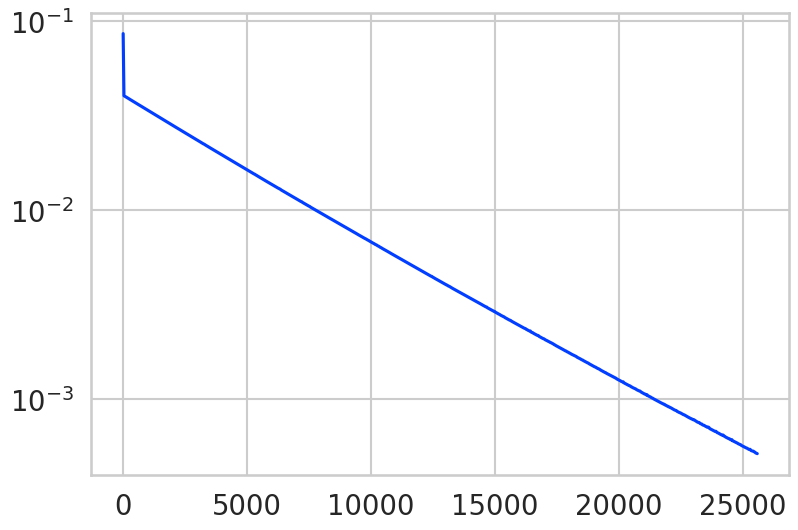

In [8]:
lr = 0.43
its_single, ts_single, losses_single, comp_single, update_single = run_single_worker_sgd(
    objective_fn=least_squares_objective, 
    A=A, 
    b=b,
    lr=0.43,
    iterations=iterations*num_workers,
    batch_size=batch_size
)

f_min_val = f_min.item()
plt.yscale('log')
plt.plot(its_single, losses_single - f_min_val, label='Single-worker SGD')

### cpu versipn

In [9]:
# A_npy = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
# x_rand_npy = rng.normal(size=dim)
# b_npy = A_npy @ x_rand_npy + noise_scale * rng.normal(size=n_data)

# def batch_grad_func(rng, x, batch_size):
#     idx = rng.choice(n_data, size=batch_size, replace=False)
#     return (A_npy[idx]@x - b_npy[idx]) @ A_npy[idx] / batch_size

# def evaluate_npy(x):
#     assert len(x) == dim
#     return 0.5 * np.mean((A_npy @ x - b_npy)**2)

# def run_single_worker_sgd(lr, iterations, batch_size):
#     """
#     Runs a single-worker (pure) minibatch SGD.
#     """
#     # rng = np.random.default_rng(42)
#     x = np.zeros(dim)
    
#     trace = []
#     its = []
#     ts = []
#     t0 = time.perf_counter()
    
#     for it in range(iterations):
#         # Calculate gradient on a large batch
#         grad = batch_grad_func(rng, x, batch_size)
        
#         # Update model
#         x -= lr * grad
        
#         if it % it_check == 0:
#             trace.append(x.copy())
#             its.append(it)
#             ts.append(time.perf_counter() - t0)
            
#     return np.asarray(its), np.asarray(ts), np.asarray([evaluate_npy(x) for x in trace])

In [10]:
# lr = 0.43
# iterations_single = iterations * num_workers
# its_single, ts_single, losses_single = run_single_worker_sgd(
#     lr=0.43,
#     iterations=iterations_single,
#     batch_size=batch_size
# )

In [11]:
# x_opt, _, _, _ = np.linalg.lstsq(A_npy, b_npy)
# f_min = evaluate_npy(x_opt)
# plt.yscale('log')
# plt.plot(its_single, losses_single - f_min, label='Single-worker SGD')

## Distributed-SGD

## Distributed Framework

In [12]:
@ray.remote
class ParameterServer(object):
    """
    Parameter server for asynchronous and synchronous SGD.
    Arguments:
        lr (float): the stepsize to be used at initialization
        asynchronous (bool): if True, use asynchronous SGD; if False, use synchronous SGD
    """

    def __init__(self, lr, asynchronous, num_workers=0, async_cached=False):
        self.x = torch.zeros(dim, 1, requires_grad=True)
        self.lr = lr
        self.asynchronous = asynchronous
        if async_cached:
            # Initialize with Tensors to avoid TypeError in torch.stack
            self.gradient_cache = [torch.zeros(dim, 1) for _ in range(num_workers)]
        else:
            self.gradient_cache = None
        
        self.update_times = []

    def apply_gradients(self, grad, *gradients):
        t_start = time.perf_counter()
        # *可以把一串位置参数打包到一个元组里
        if self.asynchronous:
                with torch.no_grad():
                    self.x -= self.lr * grad
        else:
            with torch.no_grad():
                summed_gradients = torch.sum(torch.stack(gradients), dim=0)
                self.x -= self.lr * summed_gradients
        
        t_end = time.perf_counter()
        self.update_times.append(t_end - t_start)
        return self.x
    
    def apply_cached_gradients(self, worker_id, grad):
        t_start = time.perf_counter()
        # Ensure incoming grad is a Tensor (handle potential numpy conversion by Ray)
        if isinstance(grad, np.ndarray):
            grad = torch.from_numpy(grad).float()
            
        self.gradient_cache[worker_id] = grad
        summed_gradients = torch.sum(torch.stack(self.gradient_cache), dim=0)
        
        # Use .data to update parameters to avoid autograd issues with in-place operations on leaf variables
        with torch.no_grad():
            self.x -= self.lr * summed_gradients
        
        t_end = time.perf_counter()
        self.update_times.append(t_end - t_start)
        return self.x

    def get_x(self):
        return self.x
    
    def update_lr(self, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        
    def get_hyperparams(self):
        return self.lr, self.asynchronous
    
    def get_update_times(self):
        return self.update_times
    
    
@ray.remote
class DataWorker(object):
    """
    The class for an individual Ray worker.
    Arguments:
        objective_fn (callable): the objective function to compute loss
        A_shard (np.ndarray or torch.Tensor): a shard of the data matrix A
        b_shard (np.ndarray or torch.Tensor): a shard of the data vector b
        lr (float): the stepsize to be used at initialization
        batch_size (int, optional): batch size for sampling gradients (default: 1)
        seed (int, optional): random seed to generate random variables for reproducibility (default: 0)
    """
    def __init__(self, objective_fn, A_shard, b_shard, lr, batch_size=1, seed=0):
        # runtime checks
        if not callable(objective_fn):
            raise TypeError("objective_fn must be callable and accept (A_in, b_in, x) -> scalar torch.Tensor")

        self.A = A_shard
        self.b = b_shard
        self.n_data = A_shard.shape[0]
        self.lr = lr
        self.objective_fn = objective_fn
        self.batch_size = batch_size

        # Ensure seed is an int and create a local Generator so each worker is independent.
        self.seed = int(seed)
        self.rng = np.random.default_rng(self.seed)

    def compute_gradients(self, x):
        t_start = time.perf_counter()
        # x.requires_grad = True
        x.grad= None
            
        # t0 = time.perf_counter()
        if self.batch_size is None:
            # Full gradient
            loss = self.objective_fn(self.A, self.b, x)
            loss.backward()
            grad = x.grad
        elif self.batch_size == 1:
            # Stochastic gradient
            i = int(self.rng.integers(self.n_data))
            loss = self.objective_fn(self.A[i], self.b[i], x)
            loss.backward()
            grad = x.grad
        else:
            # M-sync gradient
            idx = self.rng.choice(self.n_data, size=self.batch_size, replace=False)
            loss = self.objective_fn(self.A[idx], self.b[idx], x)
            loss.backward()
            grad = x.grad
            
        t_end = time.perf_counter()
        # Return grad, computation duration, and end timestamp
        return grad, t_end - t_start, t_end

        
    def get_hyperparams(self):
        return self.lr, self.batch_size
    
    def get_lr(self):
        return self.lr

## Distributed Algriothms

In [13]:
def run(num_workers, lr, iterations=200, asynchronous=True, delay_adaptive=False,
        batch_size=1, objective_fn=least_squares_objective,async_cached=False, seed=42):
    """Run the distributed training.

    seed: int -- used to initialize the NumPy Generator that creates per-worker seeds.
    """
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(seed)
    seeds_workers = rng.choice(max_seed, size=num_workers, replace=False)
    #seeds_workers = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(num_workers)]

    ray.init(ignore_reinit_error=True)
    
    # Partition the data and put it in the object store.
    A_shards = torch.chunk(A, num_workers)
    b_shards = torch.chunk(b, num_workers)
    A_shard_refs = [ray.put(shard) for shard in A_shards]
    b_shard_refs = [ray.put(shard) for shard in b_shards]

    # ps = ParameterServer.remote(lr, asynchronous)
    ps = ParameterServer.remote(lr, asynchronous, num_workers, async_cached=async_cached)
    # Ensure argument order matches DataWorker.__init__(objective_fn, A_shard, b_shard, lr, ...)
    workers = [DataWorker.remote(objective_fn,
                                 A_shard_refs[i], 
                                 b_shard_refs[i],
                                 lr=lr, 
                                 batch_size=batch_size, 
                                 seed=int(seeds_workers[i])) for i in range(num_workers)]

    x = ps.get_x.remote()
    
    # Stats collection
    comp_times = []
    comm_times = []
    stats_history = [] # List of dicts: {'worker_id': int, 'comp_time': float, 'comm_time': float, 'it': int}
    
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            # Store start time
            t_start = time.perf_counter() #########################################################这里后续还可以做更改
            gradients[worker.compute_gradients.remote(x)] = (worker, t_start)
            worker_id_to_num[worker] = e


    its = []
    ts = []
    delays = []
    delay = 0
    trace = []
    # grads_per_it = 1 if asynchronous else num_workers
    t0 = time.perf_counter()
    for it in range(iterations * (num_workers if asynchronous else 1)):
        # n_grads = it * grads_per_it # 异步时n_grads = it；同步时n_grads = it * num_workers
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients),num_returns=1) #ray.wait作用在任务句柄的列表上，返回已经完成的任务句柄列表和未完成的任务句柄列表，只返回一个已经完成的任务句柄。
            ready_gradient_id = ready_gradient_list[0]
            t_now = time.perf_counter() # Capture arrival time at server
            
            worker, t_task_start = gradients.pop(ready_gradient_id) #从字典 gradients 中，删除并返回 key 为 ready_gradient_id 的那个 value（也就是对应的 worker 对象 和 t_start
            worker_num = worker_id_to_num[worker]
            
            # Get result and measure time
            grad_tuple = ray.get(ready_gradient_id) # 获取已经计算完成的梯度值
            grad, t_comp, t_worker_end = grad_tuple
            
            comm_time = t_now - t_worker_end
            comp_times.append(t_comp)
            comm_times.append(comm_time)
            stats_history.append({'worker_id': worker_num, 'comp_time': t_comp, 'comm_time': comm_time, 'it': it})

            # Compute and apply gradients.
            # t_next_start = time.perf_counter()
            # gradients[worker.compute_gradients.remote(x)] = (worker, t_next_start) # 重新计算该 worker 的梯度，并将新的任务句柄存回 gradients 字典
            
            delay = it - worker_last_it[worker_num] # 计算该 worker 的延迟

            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
            if async_cached:
                x = ps.apply_cached_gradients.remote(worker_num, grad)
            else:
                x = ps.apply_gradients.remote(grad) # 针对已经计算完成的梯度进行参数更新

            
            t_next_start = time.perf_counter()
            gradients[worker.compute_gradients.remote(x)] = (worker, t_next_start) # 重新计算该 worker 的梯度，并将新的任务句柄存回 gradients 字典

            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            # Synchronous
            gradients = [worker.compute_gradients.remote(x) for worker in workers]
            ref_to_worker_id = {gradients[i]: i for i in range(len(workers))}
            
            pending = gradients[:]
            batch_grads = []
            
            # Collect all gradients, measuring arrival time for each
            while pending:
                ready_list, pending = ray.wait(pending, num_returns=1)
                t_now = time.perf_counter()
                for obj_id in ready_list:
                    grad, t_comp, t_worker_end = ray.get(obj_id)
                    w_id = ref_to_worker_id[obj_id]
                    
                    comm_time = t_now - t_worker_end
                    comp_times.append(t_comp)
                    comm_times.append(comm_time)
                    stats_history.append({'worker_id': w_id, 'comp_time': t_comp, 'comm_time': comm_time, 'it': it})
                    
                    batch_grads.append(grad)
            
            x = ps.apply_gradients.remote(None, *batch_grads)

        # if (asynchronous and not async_cached and it % it_check == 0):

        if (asynchronous and it % it_check == 0):
            # Evaluate the current model.
            x_val = ray.get(ps.get_x.remote())
            trace.append(x_val.clone().detach())
            its.append(it)
            ts.append(time.perf_counter() - t0)
        else:
            if not asynchronous:
                # Evaluate the current model.
                x_val = ray.get(ps.get_x.remote())
                trace.append(x_val.clone().detach())
                its.append(it*num_workers)
                ts.append(time.perf_counter() - t0)


        t = time.perf_counter()
        if asynchronous:
            delays.append(delay)

    # Fetch update times from PS
    update_times = ray.get(ps.get_update_times.remote())
    
    print(f"Run Stats (Async={asynchronous}, Cached={async_cached}, Adaptive={delay_adaptive}):")
    print(f"  Gradient Computation: Mean = {np.mean(comp_times):.6f} s, Var = {np.var(comp_times):.6e} s^2")
    print(f"  Parameter Update:     Mean = {np.mean(update_times):.6f} s, Var = {np.var(update_times):.6e} s^2")
    print(f"  Communication:        Mean = {np.mean(comm_times):.6f} s, Var = {np.var(comm_times):.6e} s^2")

    ray.shutdown()
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace]), np.asarray(delays), np.asarray(comp_times), np.asarray(update_times), np.asarray(comm_times), stats_history

### Synchronous Experiments

In [14]:
lr_asc = 0.001 # best tuned
its_asc, ts_asc, losses_asc, delays, comp_asc, update_asc, comm_asc, stats_asc = run(num_workers, lr=lr_asc,
                                 iterations=iterations,
                                 asynchronous=True,
                                 delay_adaptive=False,
                                 batch_size=batch_size// num_workers,
                                 async_cached=True)

2025-11-26 16:38:38,470	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


2025-11-26 16:38:38,470	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Run Stats (Async=True, Cached=True, Adaptive=False):
  Gradient Computation: Mean = 0.002350 s, Var = 1.200716e-03 s^2
  Parameter Update:     Mean = 0.000108 s, Var = 4.148666e-09 s^2
  Communication:        Mean = 0.030621 s, Var = 1.868525e-03 s^2


In [15]:
lr_mini = 0.19 # best tuned
its_, ts_, losses_, delays, comp_sync, update_sync, comm_sync, stats_sync = run(num_workers, lr=lr_mini,
                                 iterations=iterations,
                                 asynchronous=False,
                                 delay_adaptive=False,
                                 batch_size=batch_size// num_workers,
                                 async_cached=False)

2025-11-26 16:39:19,493	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2025-11-26 16:39:19,493	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Run Stats (Async=False, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 0.002558 s, Var = 1.540660e-03 s^2
  Parameter Update:     Mean = 0.000276 s, Var = 6.241685e-08 s^2
  Communication:        Mean = 0.012107 s, Var = 3.846266e-05 s^2


### Asynchronous Experiments

In [16]:
lr_as = 0.43 # best tuned
its_as, ts_as, losses_as, delays, comp_as, update_as, comm_as, stats_as = run(num_workers, lr=lr_as,
                                       iterations=iterations,
                                       asynchronous=True,
                                       delay_adaptive=False,
                                       batch_size=batch_size,
                                       async_cached=False)

2025-11-26 16:40:20,995	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2025-11-26 16:40:20,995	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Run Stats (Async=True, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 0.003697 s, Var = 1.151022e-03 s^2
  Parameter Update:     Mean = 0.000062 s, Var = 1.103903e-09 s^2
  Communication:        Mean = 0.030504 s, Var = 1.535248e-03 s^2


In [17]:
lr_ad = 0.43 # best tuned
its_ad, ts_ad, losses_ad, delays, comp_ad, update_ad, comm_ad, stats_ad = run(num_workers, lr=lr_ad,
                                       iterations=iterations,
                                       asynchronous=True,
                                       delay_adaptive=True,
                                       batch_size=batch_size,
                                       async_cached=False)

2025-11-26 16:41:03,376	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2025-11-26 16:41:03,376	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Run Stats (Async=True, Cached=False, Adaptive=True):
  Gradient Computation: Mean = 0.003650 s, Var = 1.090523e-03 s^2
  Parameter Update:     Mean = 0.000061 s, Var = 5.201518e-10 s^2
  Communication:        Mean = 0.040127 s, Var = 3.477964e-03 s^2


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

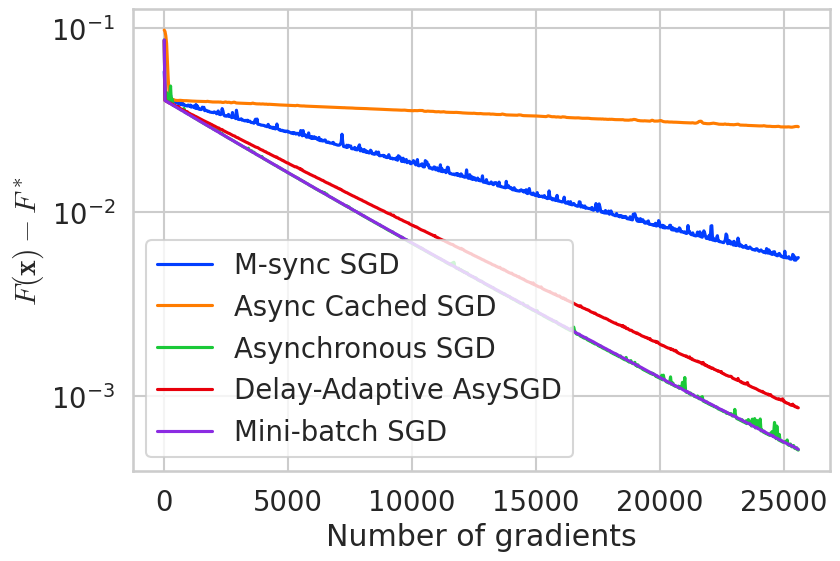

In [18]:
plt.plot(its_ , losses_ - f_min_val, label='M-sync SGD')
plt.plot(its_asc , losses_asc - f_min_val, label='Async Cached SGD')
plt.plot(its_as , losses_as - f_min_val, label='Asynchronous SGD')
plt.plot(its_ad , losses_ad - f_min_val, label='Delay-Adaptive AsySGD')
plt.plot(its_single, losses_single - f_min_val, label='Mini-batch SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

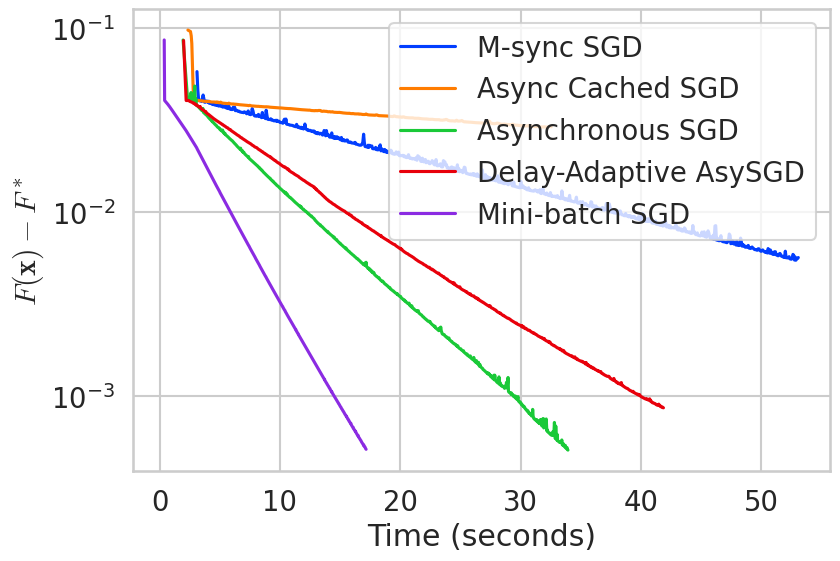

In [19]:
plt.plot(ts_ , losses_ - f_min_val, label='M-sync SGD')
plt.plot(ts_asc, losses_asc - f_min_val, label='Async Cached SGD')
plt.plot(ts_as, losses_as - f_min_val, label='Asynchronous SGD')
plt.plot(ts_ad, losses_ad - f_min_val, label='Delay-Adaptive AsySGD')
plt.plot(ts_single, losses_single - f_min_val, label='Mini-batch SGD')

plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

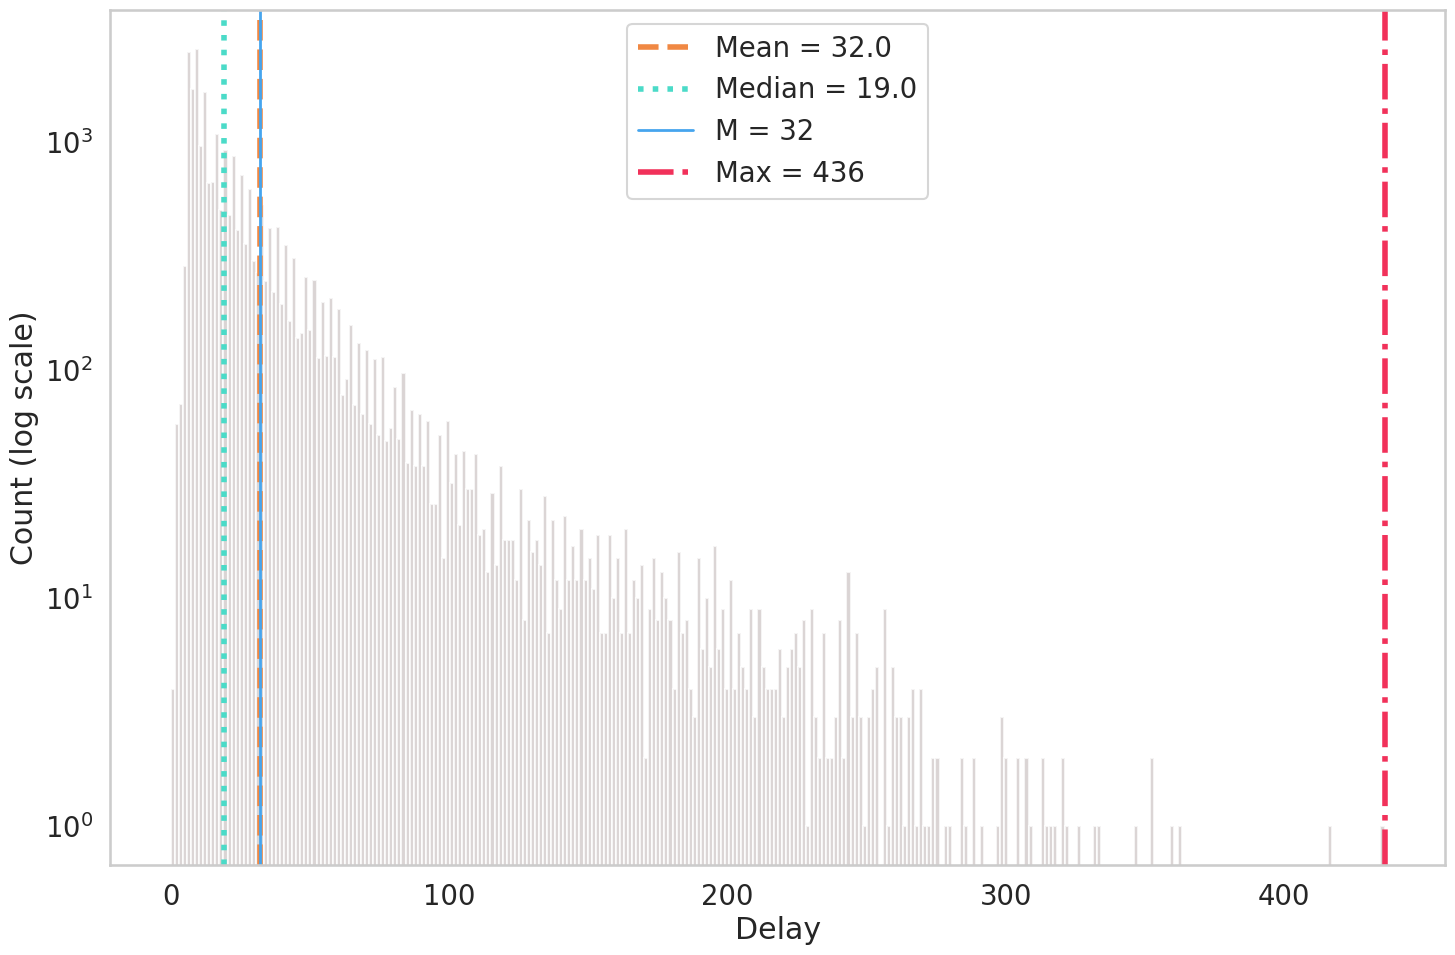

In [20]:
plt.figure(figsize=(15,10))

# delay 直方图
plt.hist(delays, bins=300, color="#CEC6C6", alpha=0.75)
plt.yscale('log')

# 统计量
mean_delay = np.mean(delays)
median_delay = np.median(delays)
max_delay = np.max(delays)

plt.axvline(mean_delay, color="#f08843", linestyle='--', linewidth=4, label=f'Mean = {mean_delay:.1f}')
plt.axvline(median_delay, color="#4bdbc8", linestyle=':', linewidth=4, label=f'Median = {median_delay:.1f}')
plt.axvline(num_workers, color="#46a5ee", linestyle='-', linewidth=2, label=f'M = {num_workers}')
plt.axvline(max_delay, color="#f1315a", linestyle='-.', linewidth=4, label=f'Max = {max_delay:.0f}')
plt.grid(False)
plt.xlabel('Delay')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()


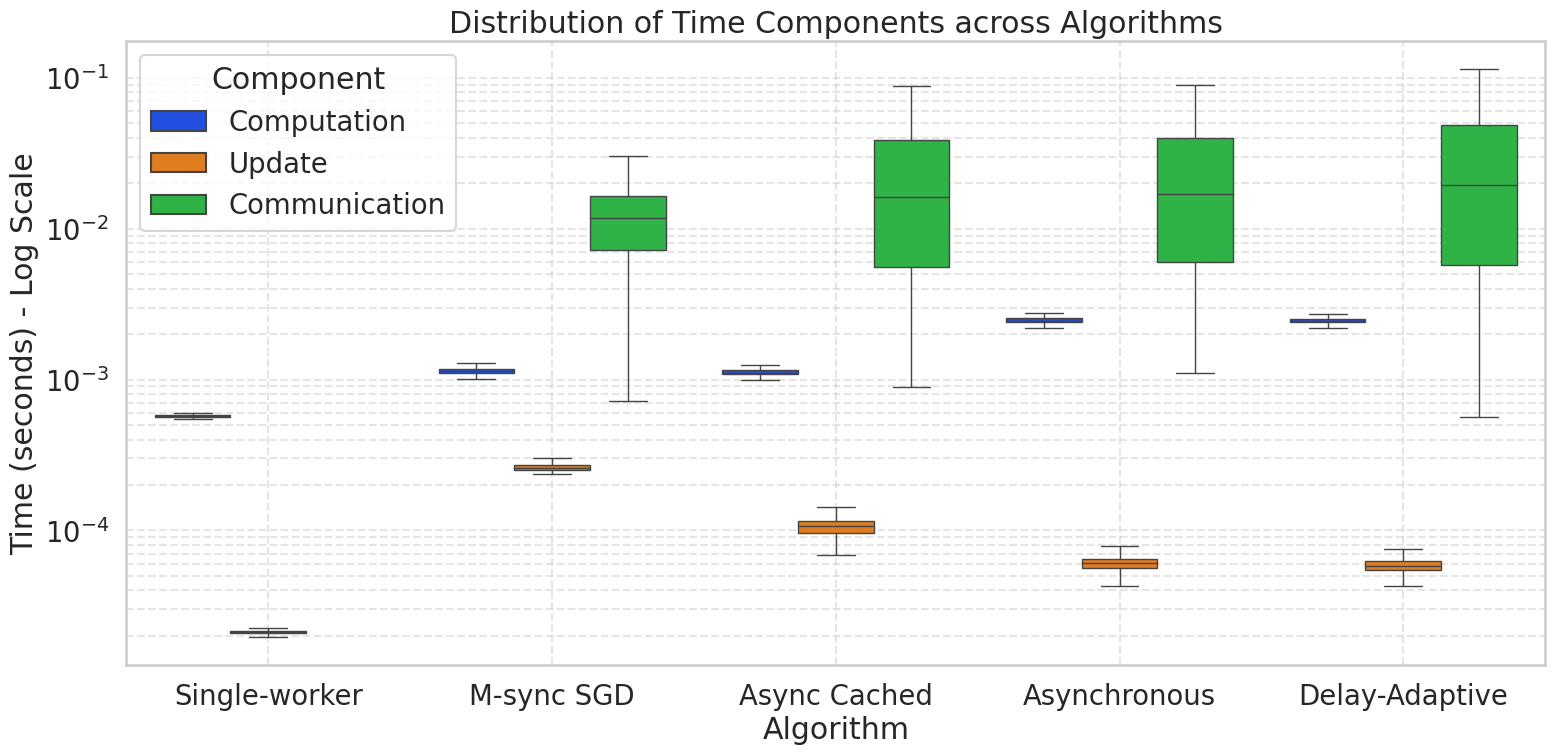

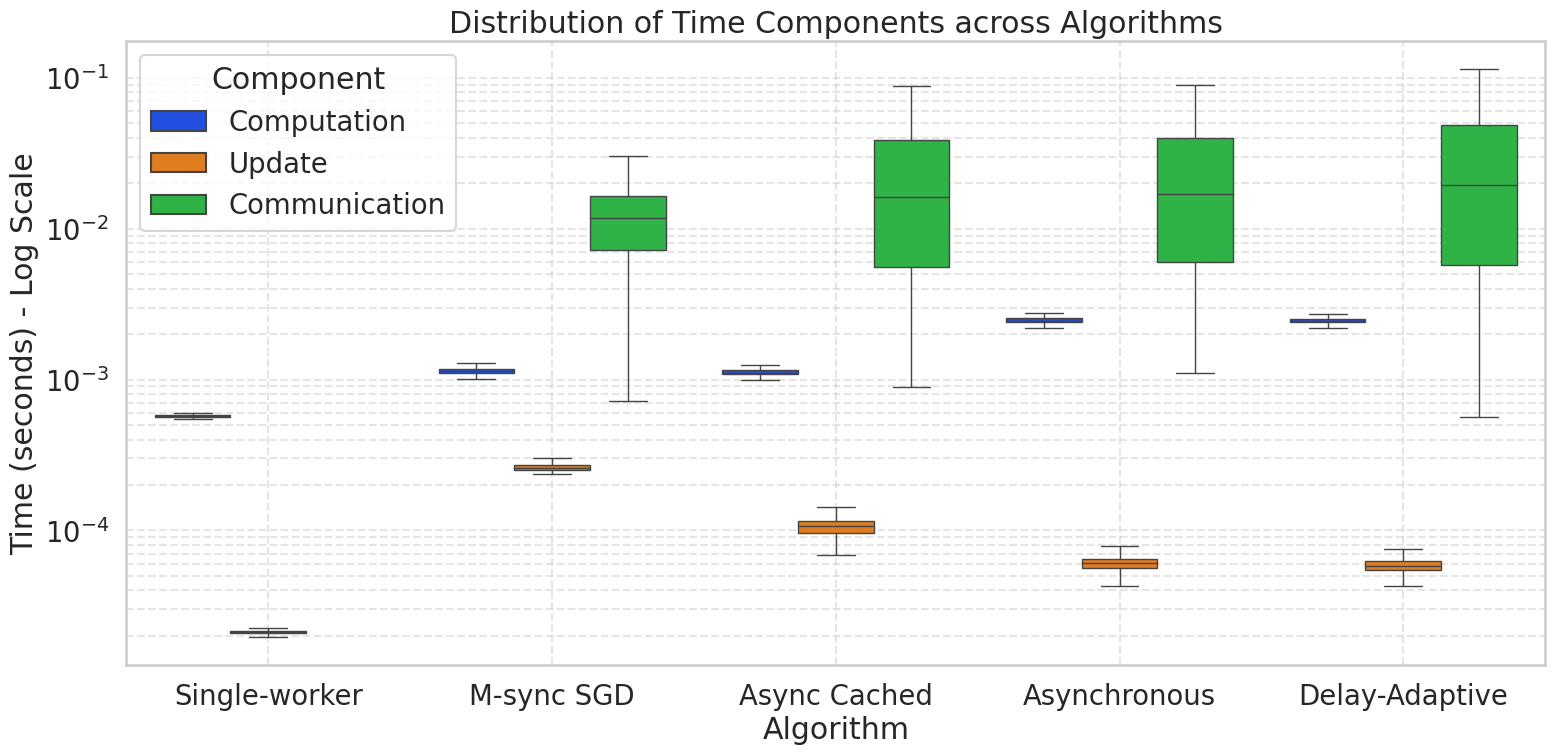

/tmp/ipykernel_1141211/4129967895.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


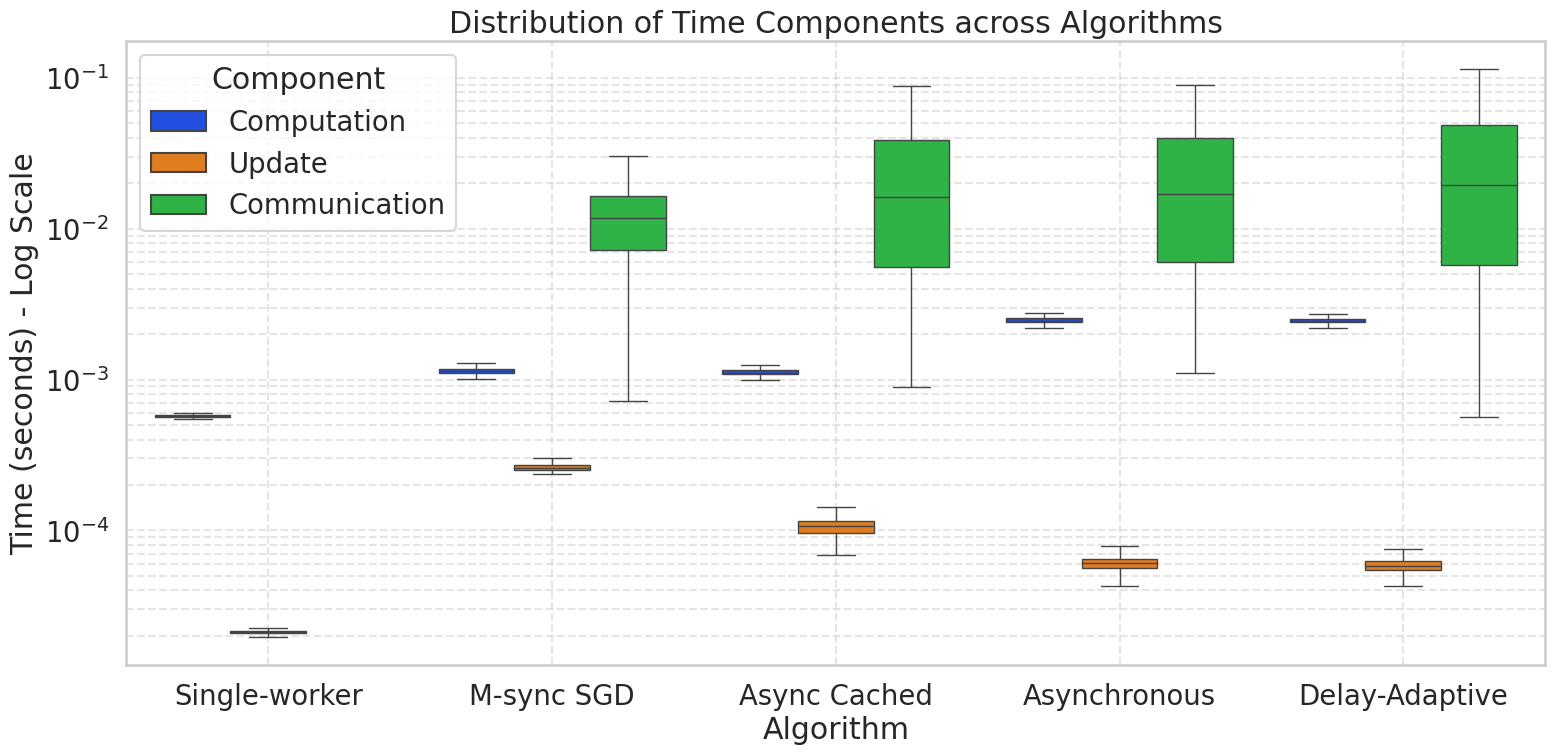

/tmp/ipykernel_1141211/4129967895.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
/tmp/ipykernel_1141211/4129967895.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


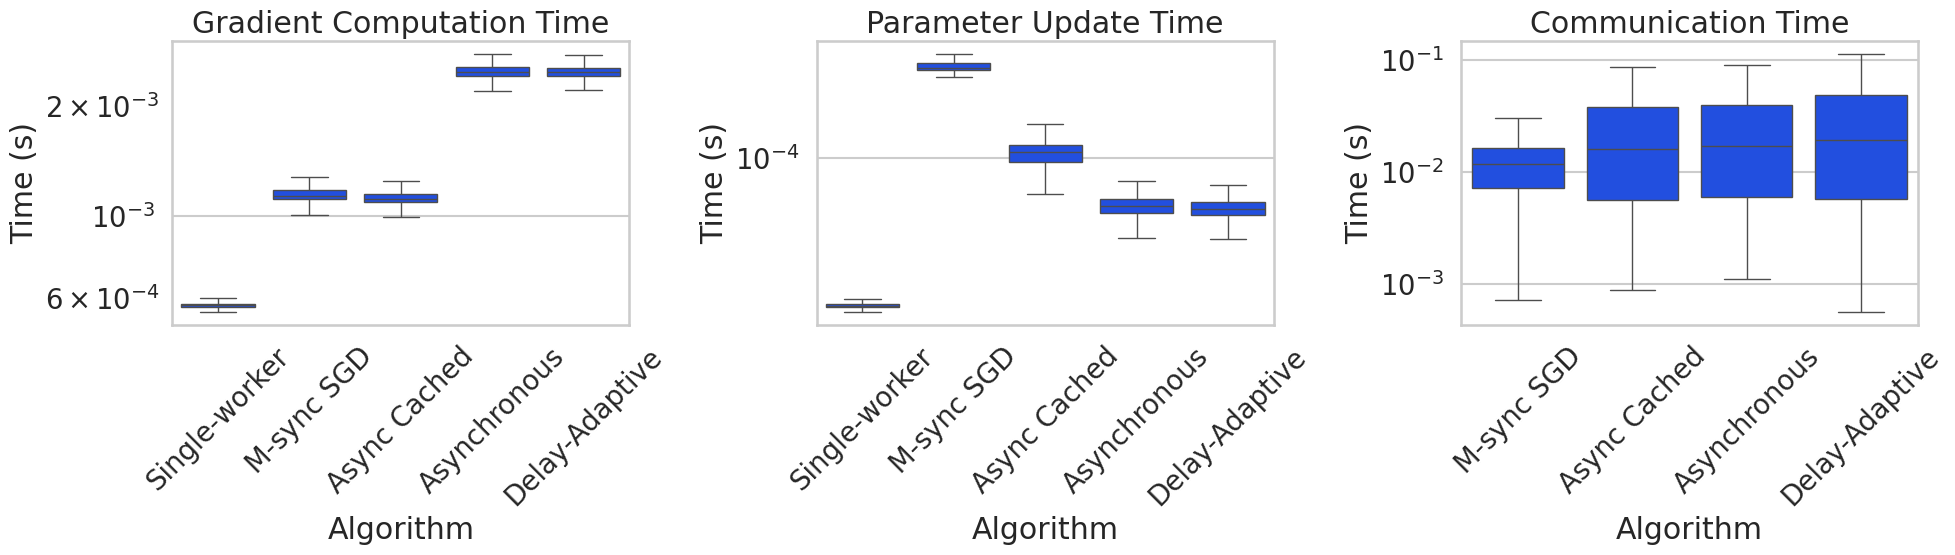

In [21]:
# Visualization of Time Distributions
import pandas as pd

# Prepare data for plotting
data = []

# Helper to add data
def add_data(alg_name, comp, update, comm=None):
    for v in comp:
        data.append({'Algorithm': alg_name, 'Type': 'Computation', 'Time (s)': v})
    for v in update:
        data.append({'Algorithm': alg_name, 'Type': 'Update', 'Time (s)': v})
    if comm is not None:
        for v in comm:
            data.append({'Algorithm': alg_name, 'Type': 'Communication', 'Time (s)': v})

add_data('Single-worker', comp_single, update_single)
add_data('M-sync SGD', comp_sync, update_sync, comm_sync)
add_data('Async Cached', comp_asc, update_asc, comm_asc)
add_data('Asynchronous', comp_as, update_as, comm_as)
add_data('Delay-Adaptive', comp_ad, update_ad, comm_ad)

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(16, 8))
sns.boxplot(x='Algorithm', y='Time (s)', hue='Type', data=df, showfliers=False) # showfliers=False to hide outliers for better scale
plt.title('Distribution of Time Components across Algorithms')
plt.yscale('log') # Log scale to see small values (like updates) and large values (like comms) together
plt.ylabel('Time (seconds) - Log Scale')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(title='Component')
plt.tight_layout()
plt.show()

# Separate plots for clearer view if scales are too different
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x='Algorithm', y='Time (s)', data=df[df['Type']=='Computation'], ax=axes[0], showfliers=False)
axes[0].set_title('Gradient Computation Time')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_yscale('log')

sns.boxplot(x='Algorithm', y='Time (s)', data=df[df['Type']=='Update'], ax=axes[1], showfliers=False)
axes[1].set_title('Parameter Update Time')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yscale('log')

sns.boxplot(x='Algorithm', y='Time (s)', data=df[df['Type']=='Communication'], ax=axes[2], showfliers=False)
axes[2].set_title('Communication Time')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

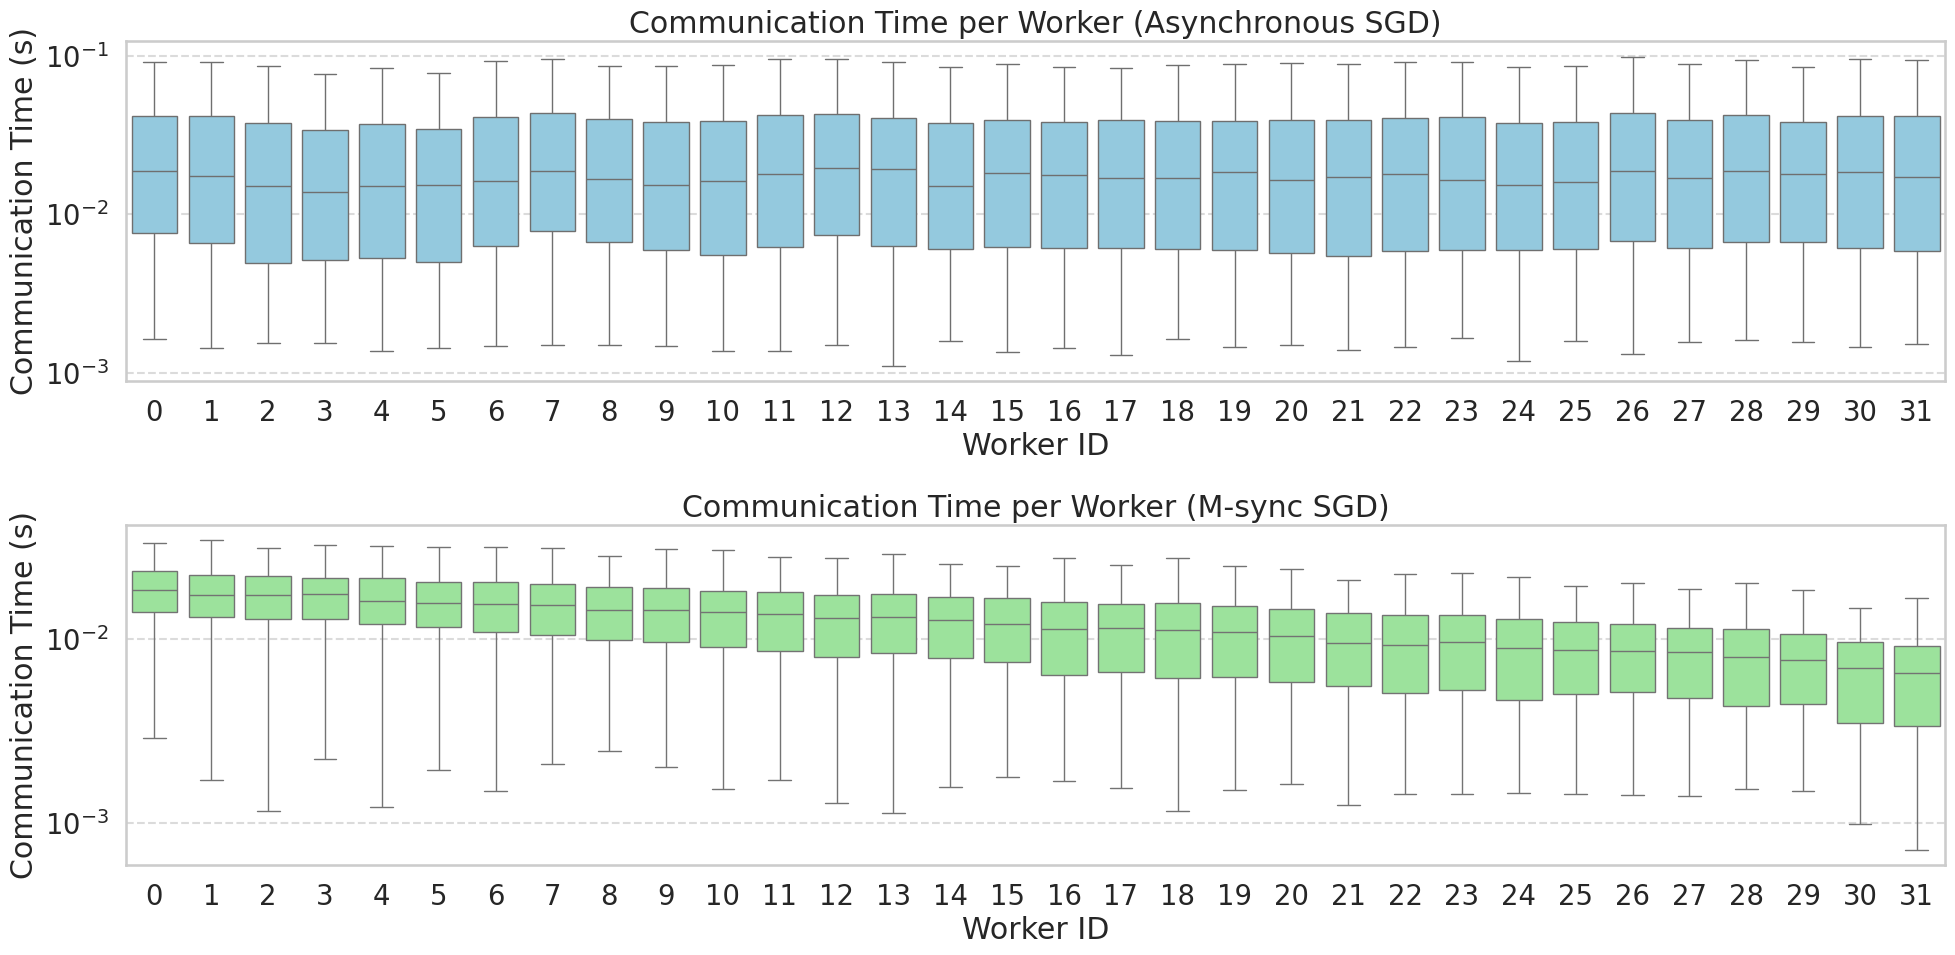

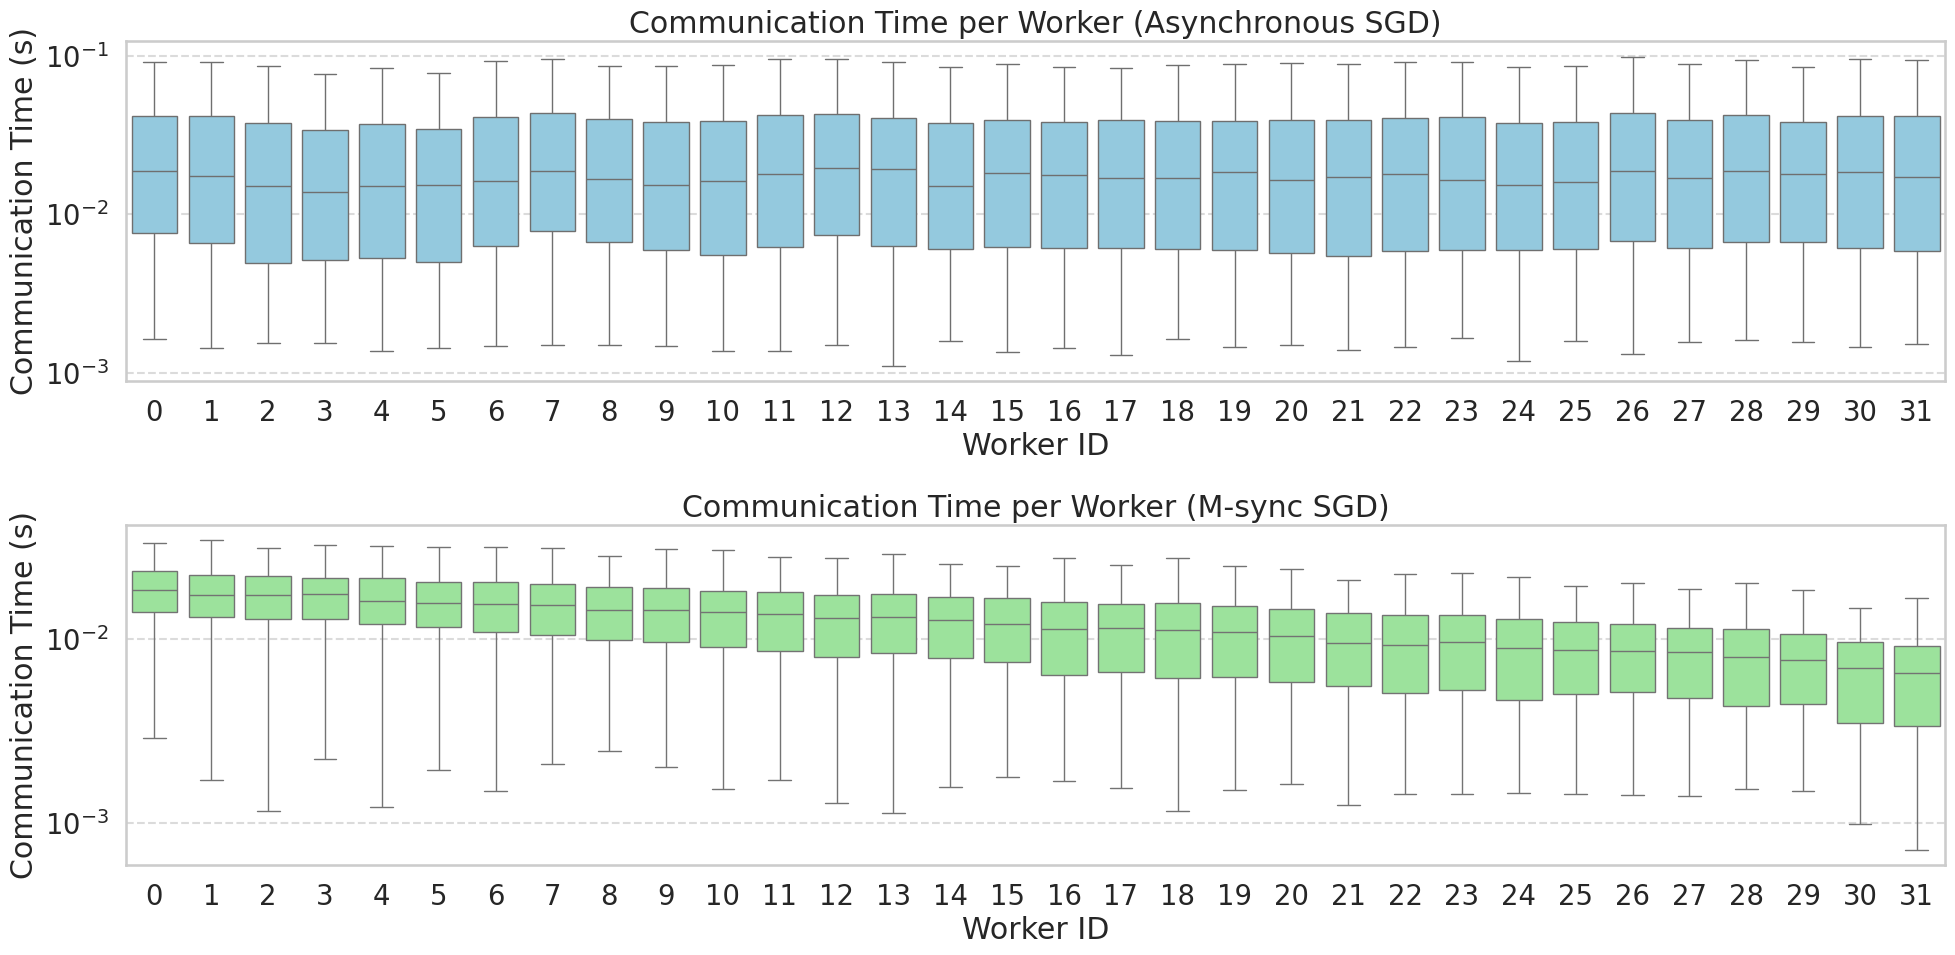

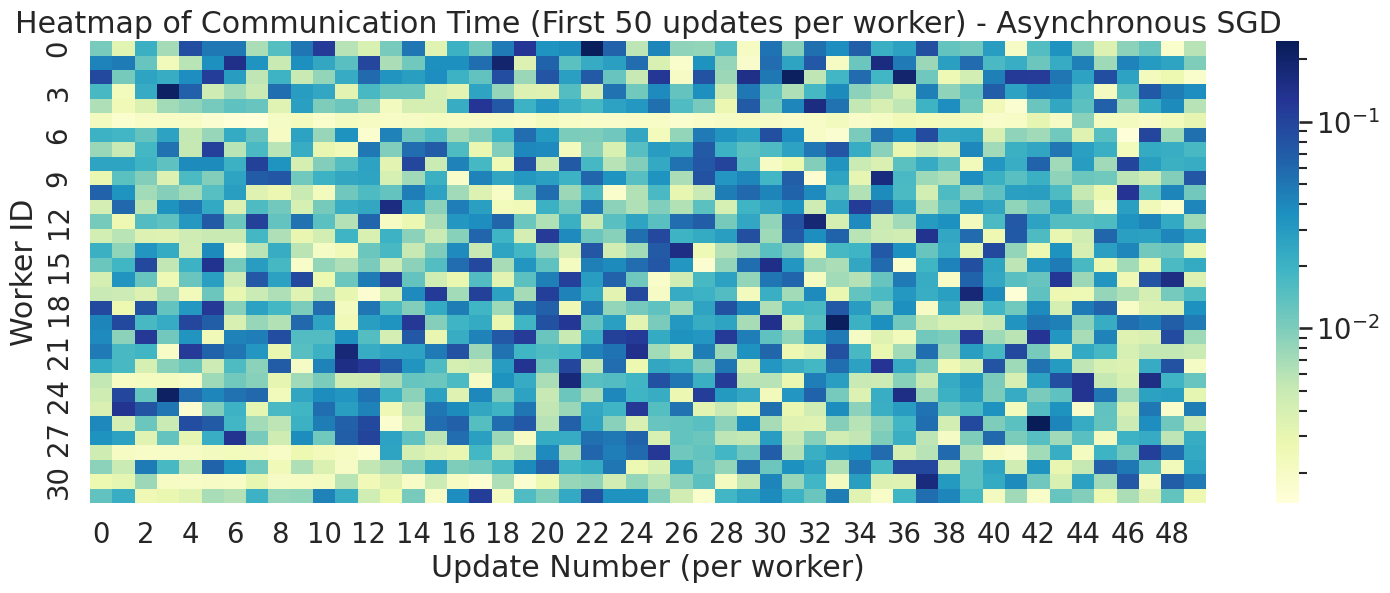

In [22]:
# Visualization of Communication Time per Worker
plt.figure(figsize=(20, 10))

# Helper to prepare dataframe for per-worker stats
def get_worker_comm_df(stats_list, alg_name):
    rows = []
    for item in stats_list:
        rows.append({
            'Worker ID': item['worker_id'],
            'Communication Time (s)': item['comm_time'],
            'Algorithm': alg_name
        })
    return pd.DataFrame(rows)

df_sync = get_worker_comm_df(stats_sync, 'M-sync SGD')
df_async = get_worker_comm_df(stats_as, 'Asynchronous SGD')
df_async_cached = get_worker_comm_df(stats_asc, 'Async Cached SGD')
df_adaptive = get_worker_comm_df(stats_ad, 'Delay-Adaptive AsySGD')

# Combine all (or select one to view)
# Let's plot Asynchronous SGD as it's the most relevant for per-worker variance
df_all_workers = pd.concat([df_sync, df_async, df_async_cached, df_adaptive])

# Plotting Asynchronous SGD specifically first
plt.subplot(2, 1, 1)
sns.boxplot(x='Worker ID', y='Communication Time (s)', data=df_async, color='skyblue', showfliers=False)
plt.title('Communication Time per Worker (Asynchronous SGD)')
plt.yscale('log')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Plotting M-sync SGD
plt.subplot(2, 1, 2)
sns.boxplot(x='Worker ID', y='Communication Time (s)', data=df_sync, color='lightgreen', showfliers=False)
plt.title('Communication Time per Worker (M-sync SGD)')
plt.yscale('log')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Optional: Heatmap of communication time over iterations for one algorithm
plt.figure(figsize=(18, 6))
# Pivot data for heatmap: Index=Iteration, Columns=Worker ID, Values=Comm Time
# Note: For Async, not all workers update in every "iteration" of the main loop in the same way, 
# but we recorded 'it' in stats.
# Let's just take the first 100 updates for each worker to visualize
df_async_subset = df_async.groupby('Worker ID').head(50).copy()
df_async_subset['Update Index'] = df_async_subset.groupby('Worker ID').cumcount()
pivot_table = df_async_subset.pivot(index='Worker ID', columns='Update Index', values='Communication Time (s)')

sns.heatmap(pivot_table, cmap="YlGnBu", norm=matplotlib.colors.LogNorm())
plt.title('Heatmap of Communication Time (First 50 updates per worker) - Asynchronous SGD')
plt.xlabel('Update Number (per worker)')
plt.show()

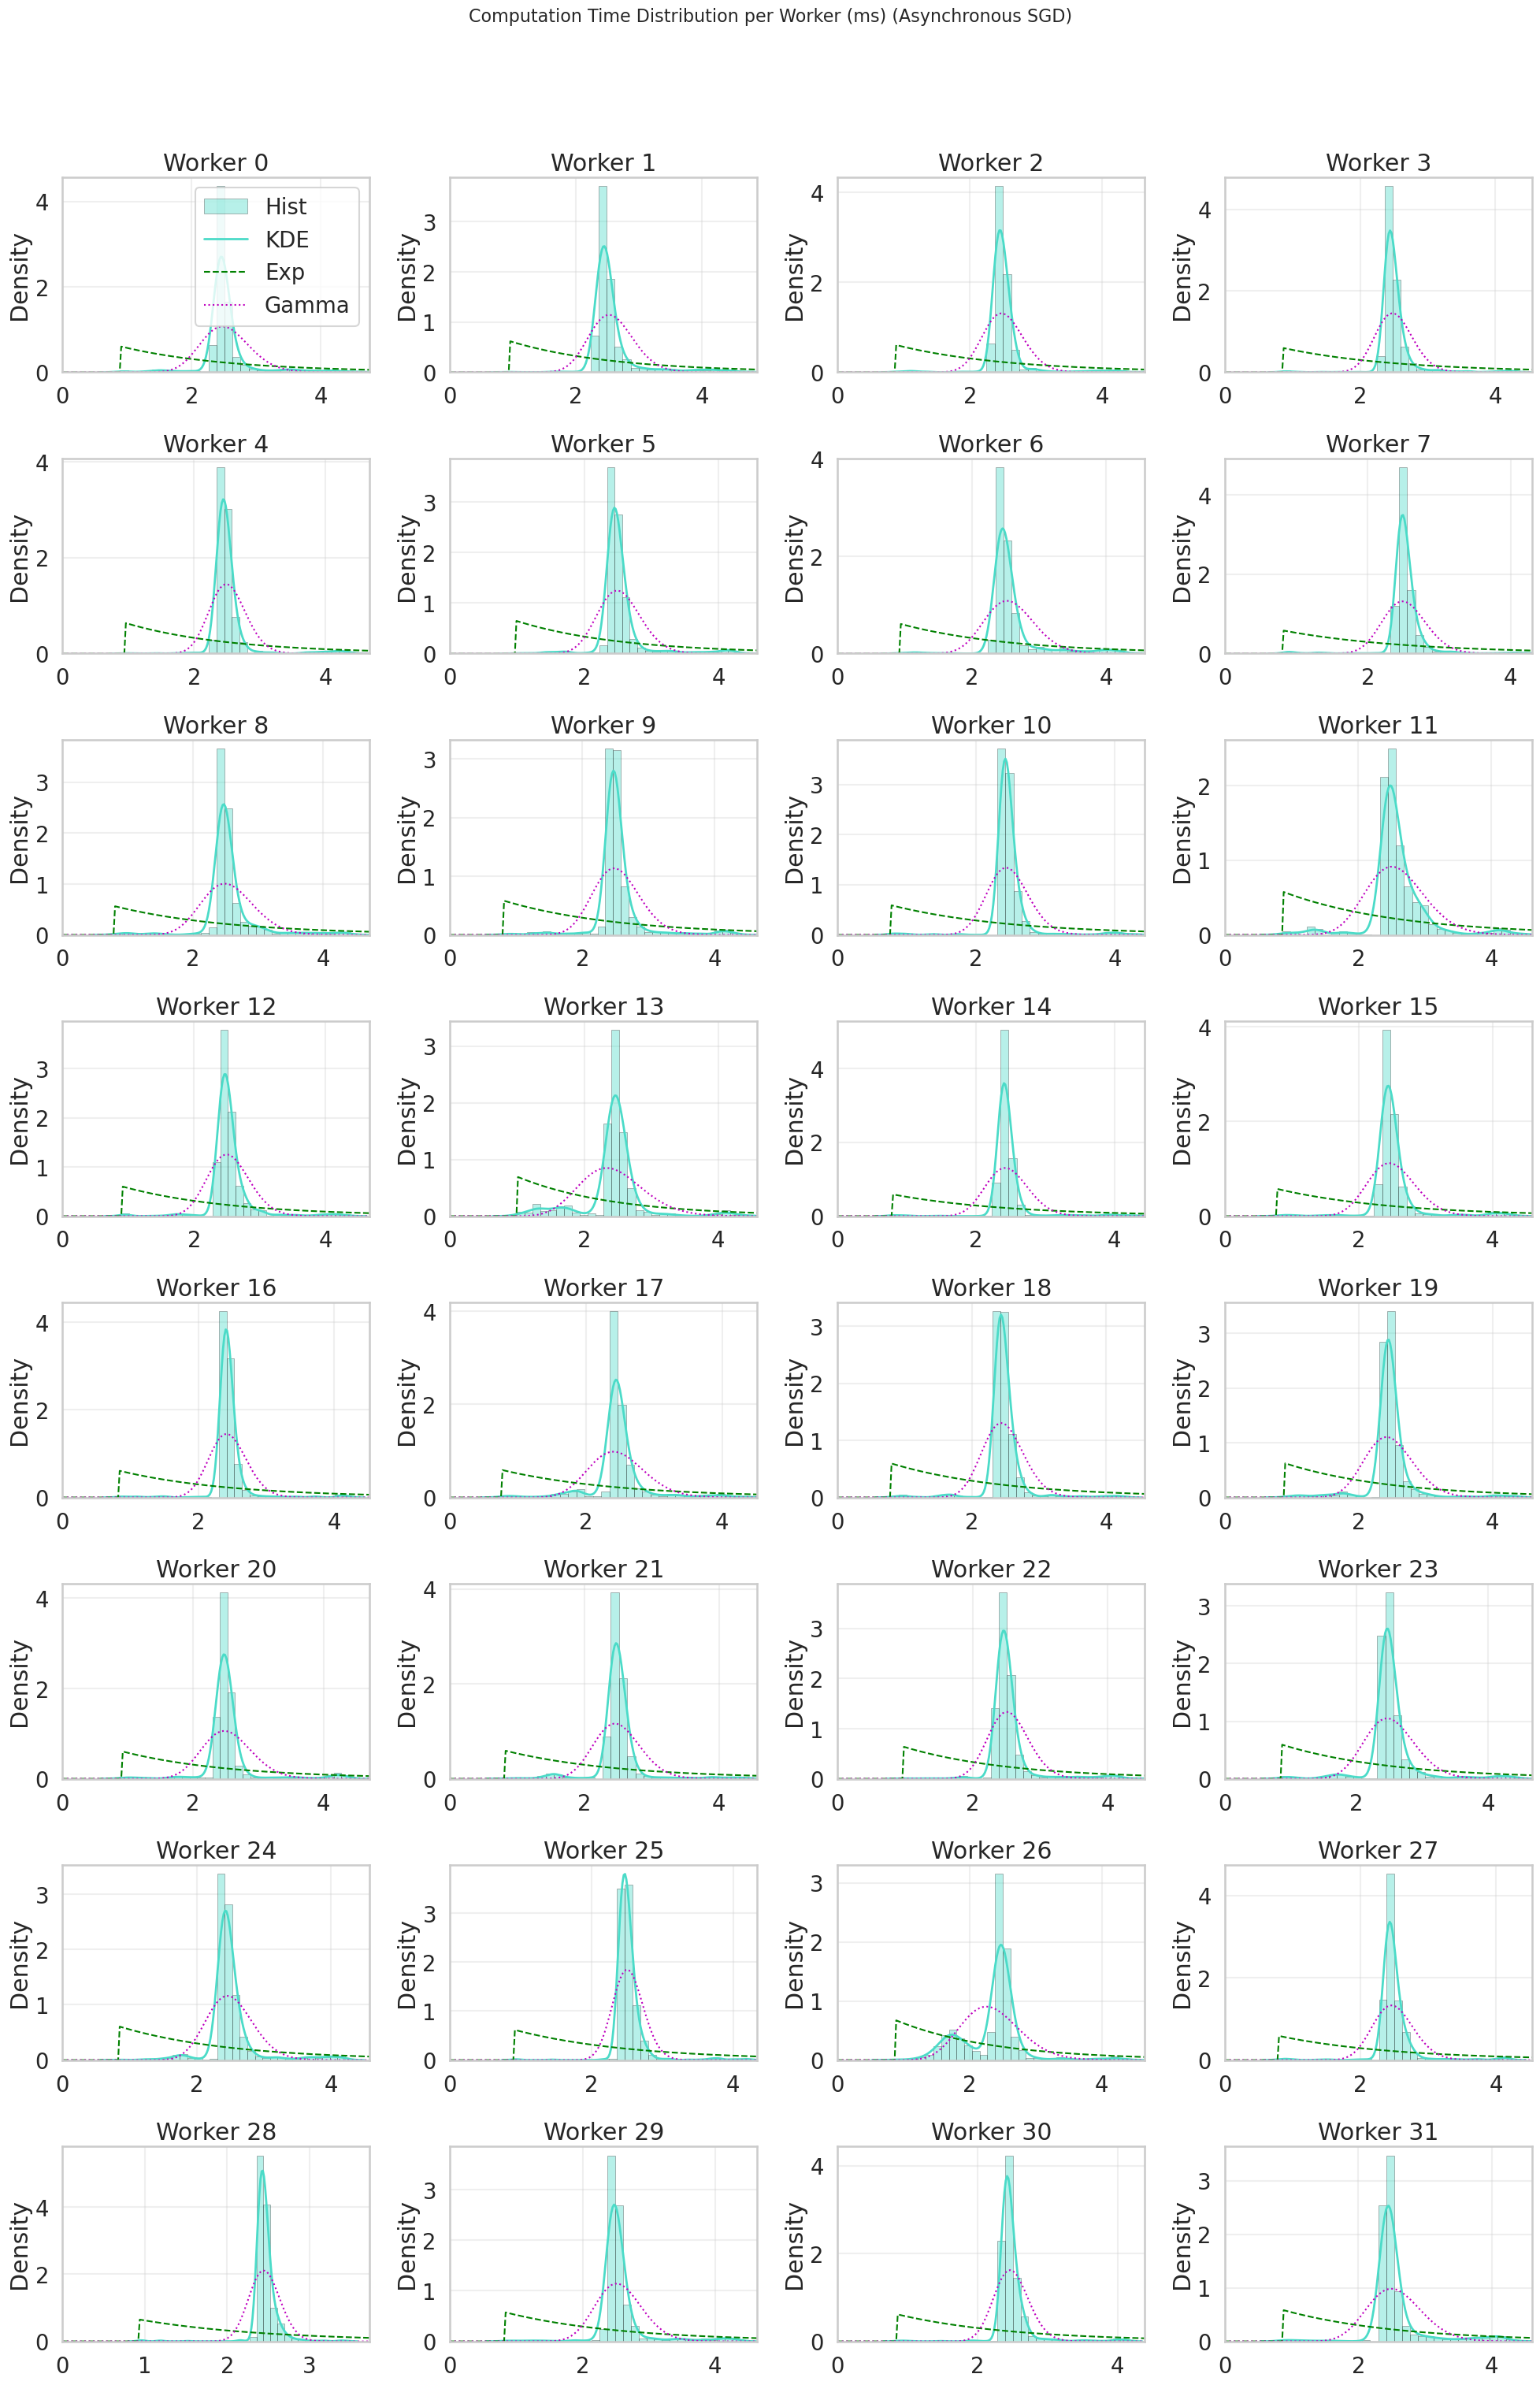

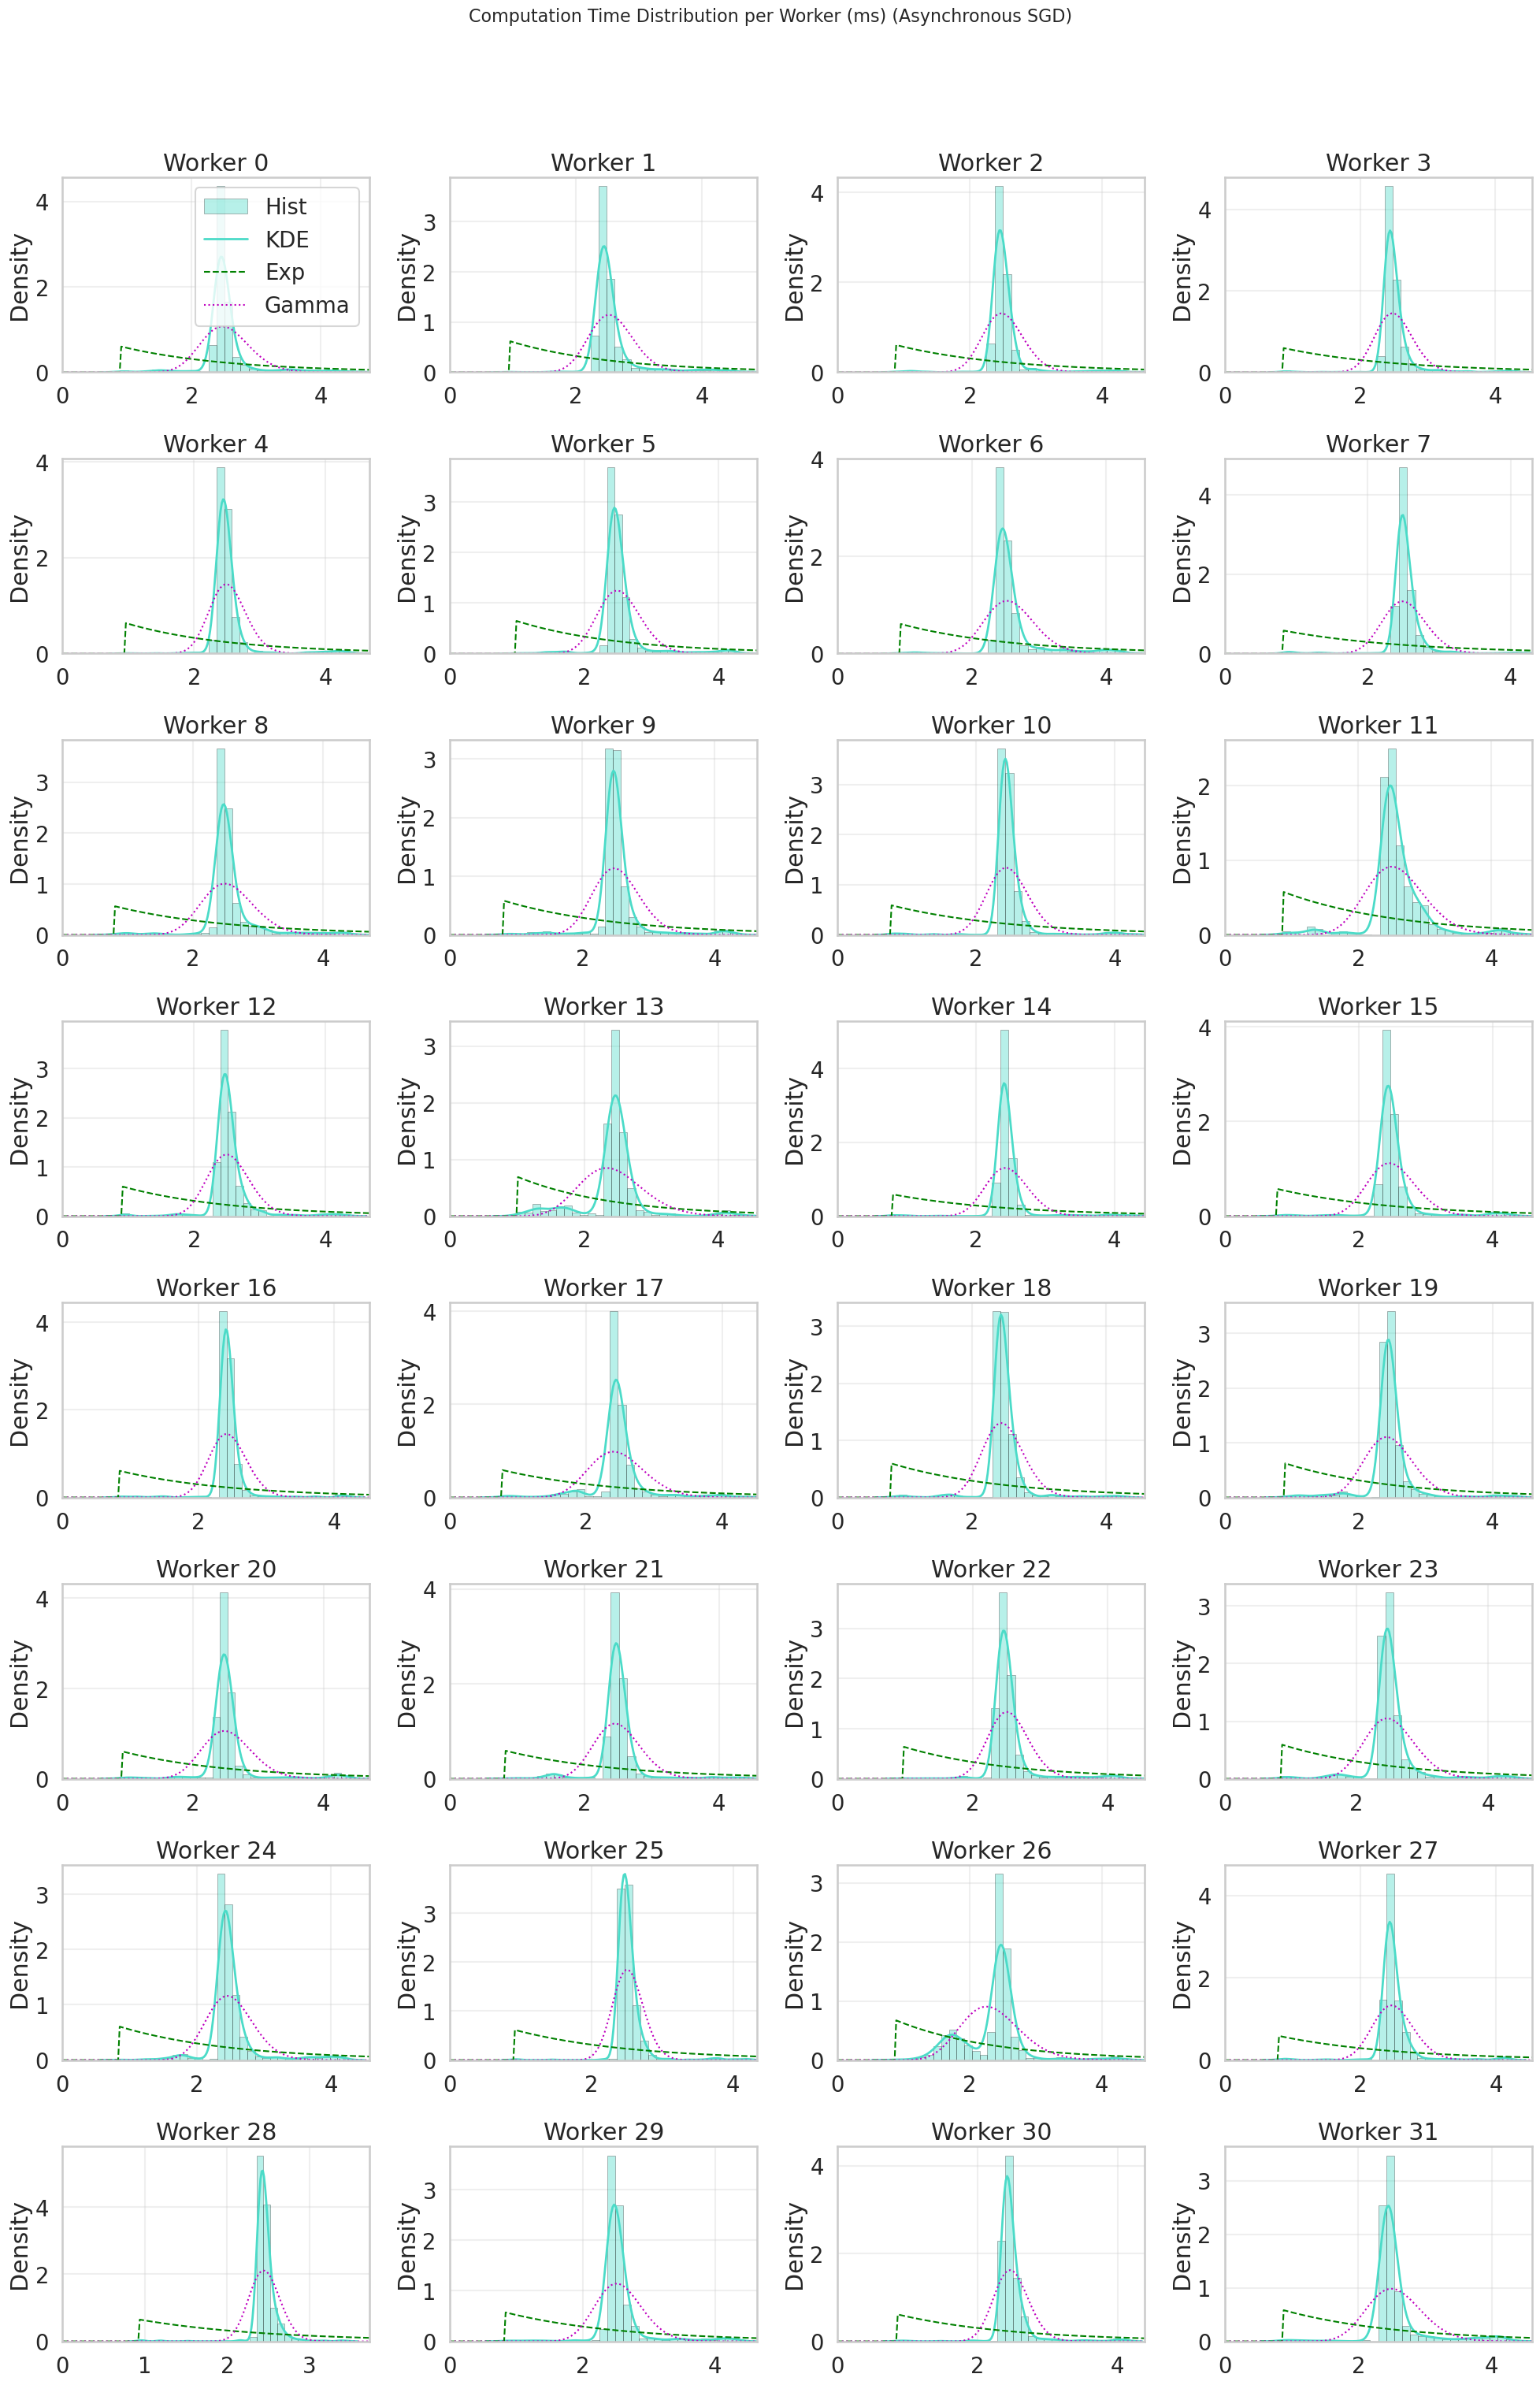

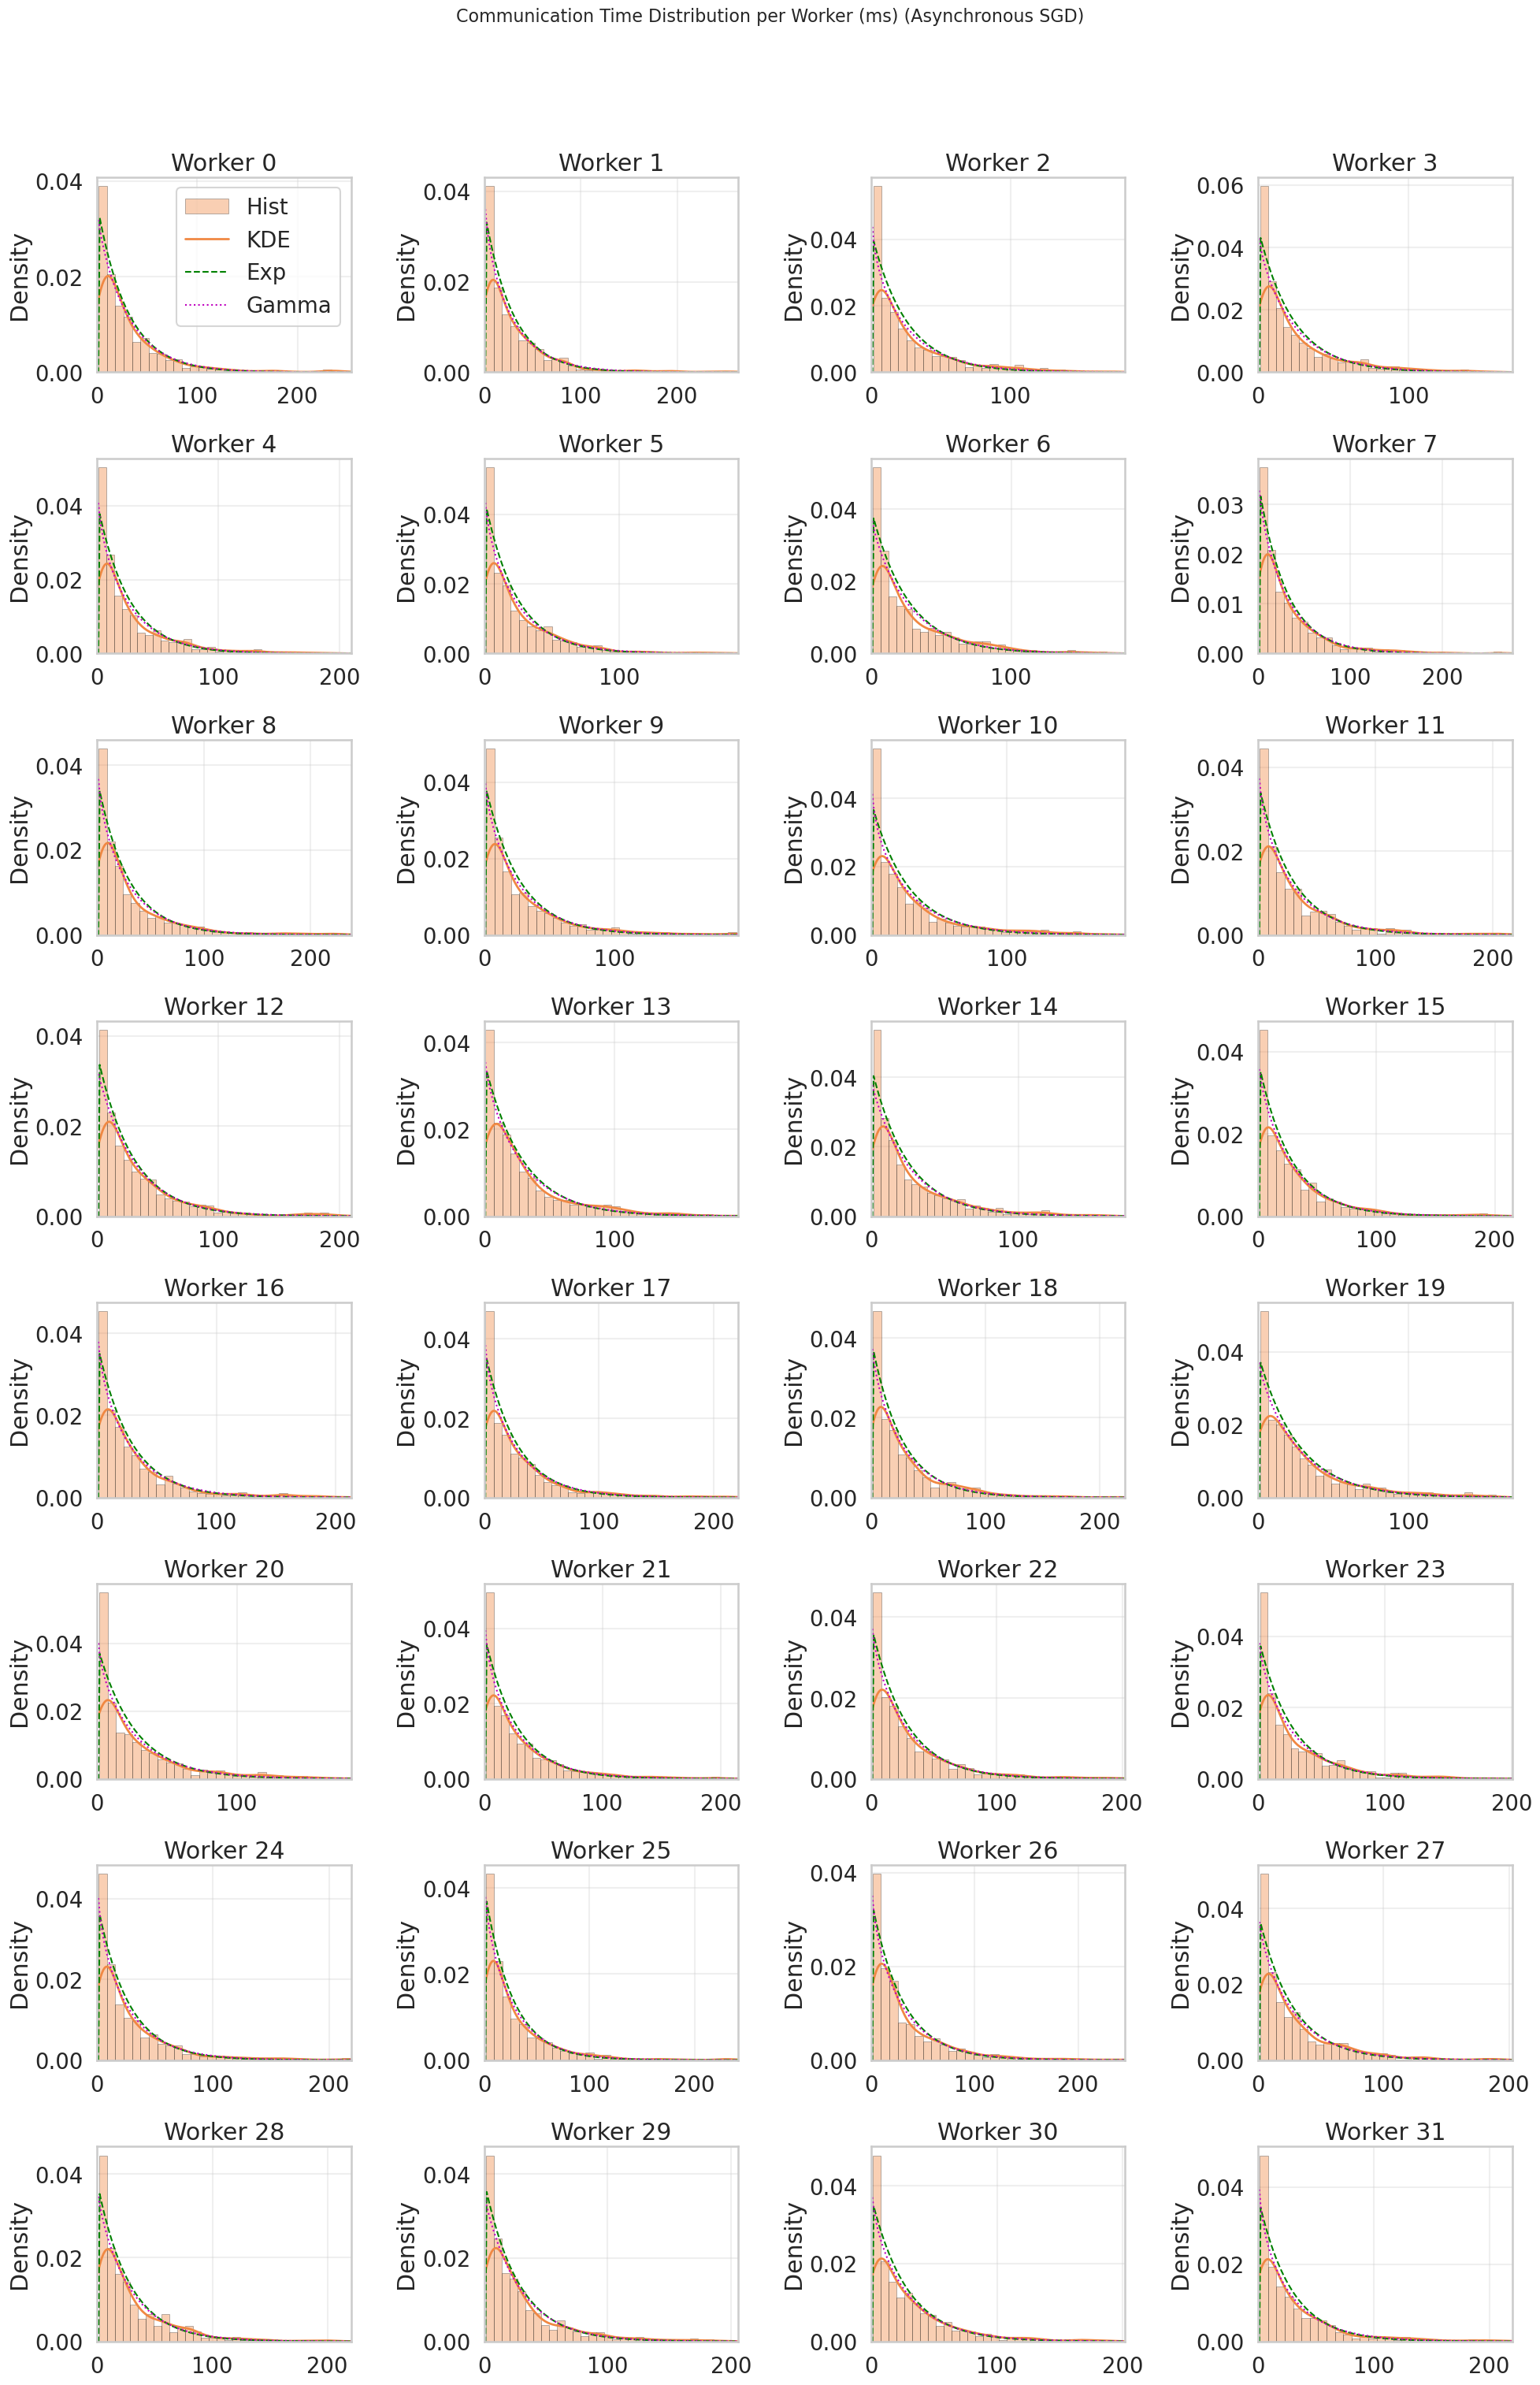

In [ ]:
# Visualization: Per-Worker Histograms with Distribution Curves (KDE + Theoretical Fits)
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from scipy import stats

# Focus on Asynchronous SGD for interesting variance
if 'stats_as' in locals():
    data_source = stats_as
    title_suffix = "(Asynchronous SGD)"
elif 'stats_sync' in locals():
    data_source = stats_sync
    title_suffix = "(Synchronous SGD)"
else:
    data_source = []
    print("No stats data found. Please run the experiments first.")

if data_source:
    worker_ids = sorted(list(set(d['worker_id'] for d in data_source)))
    n_workers = len(worker_ids)
    
    # Determine grid size (e.g., 4 columns)
    cols = 14
    rows = math.ceil(n_workers / cols)
    
    # Helper function to plot fits
    def plot_with_fits(ax, data, color, label_prefix):
        # Convert to milliseconds.
        data_ms = np.array(data) * 1000 
        
        # Filter outliers for visualization (keep 99% of data)
        # This prevents a single large outlier from squashing the entire plot
        p99 = np.percentile(data_ms, 99)
        # Add a small buffer to the limit, but ensure we don't have a 0 range
        limit = p99 * 1.1 if p99 > 0 else 1.0
        
        # Select data for plotting (we still fit on all data, or filtered data? 
        # Fitting on filtered data is better for visual match in the bulk)
        data_plot = data_ms[data_ms <= limit]
        
        if len(data_plot) < 2 or np.var(data_plot) < 1e-6:
            ax.text(0.5, 0.5, "Low Variance / No Data", transform=ax.transAxes, ha='center')
            return

        # Histogram
        # Use 'auto' bins or a fixed number based on range
        ax.hist(data_plot, bins=30, density=True, color=color, alpha=0.4, edgecolor='black', linewidth=0.5, label='Hist')
        
        # X-Range for curves
        x_range = np.linspace(0, limit, 200)
        
        # KDE
        try:
            sns.kdeplot(data_plot, ax=ax, color=color, linewidth=2, label='KDE', clip=(0, limit))
        except: pass
        
        # Theoretical Fits (Fit on the plotted data to match the visual histogram)
        # Exponential Fit
        try:
            loc, scale = stats.expon.fit(data_plot)
            ax.plot(x_range, stats.expon.pdf(x_range, loc, scale), 'g--', linewidth=1.5, label='Exp')
        except: pass

        # Gamma Fit
        try:
            # We enforce loc=0 for Gamma to represent delay starting from 0 (or near it)
            # strictly positive times usually fit better with floc=0
            a, loc, scale = stats.gamma.fit(data_plot, floc=0) 
            ax.plot(x_range, stats.gamma.pdf(x_range, a, loc, scale), 'm:', linewidth=1.5, label='Gamma')
        except: pass
        
        ax.set_xlim(0, limit)

    # 1. Computation Times Per Worker
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.suptitle(f'Computation Time Distribution per Worker (ms) {title_suffix}', fontsize=16)
    axes = axes.flatten()
    
    for i, w_id in enumerate(worker_ids):
        w_stats = [d['comp_time'] for d in data_source if d['worker_id'] == w_id]
        ax = axes[i]
        plot_with_fits(ax, w_stats, '#4bdbc8', 'Comp')
        ax.set_title(f'Worker {w_id}')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()
        
    for i in range(n_workers, len(axes)): axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 2. Communication Times Per Worker
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.suptitle(f'Communication Time Distribution per Worker (ms) {title_suffix}', fontsize=16)
    axes = axes.flatten()
    
    for i, w_id in enumerate(worker_ids):
        w_stats = [d['comm_time'] for d in data_source if d['worker_id'] == w_id]
        ax = axes[i]
        plot_with_fits(ax, w_stats, '#f08843', 'Comm')
        ax.set_title(f'Worker {w_id}')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    for i in range(n_workers, len(axes)): axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [24]:

# batch_sizes_to_test = [8, 16, 32, 64, 128]
# results = {}

# # 为所有批处理大小使用相同的预设学习率，以便进行统一比较。
# # 同步算法的学习率设置为0.19，异步算法为0.43。
# lr_sync = 0.19
# lr_async = 0.43
# f_min_val = f_min.item()

# for bs in batch_sizes_to_test:
#     print(f"--- Running for batch_size = {bs} ---")
    
#     # (M-sync SGD)
#     print("Running Synchronous SGD...")
#     its_sync, ts_sync, losses_sync, _ = run(
#         num_workers, lr=lr_sync, iterations=iterations, 
#         asynchronous=False, delay_adaptive=False, batch_size=bs
#     )
    
#     # 异步算法
#     print("Running Asynchronous SGD...")
#     its_async, ts_async, losses_async, _ = run(
#         num_workers, lr=lr_async, iterations=iterations, 
#         asynchronous=True, delay_adaptive=False, batch_size=bs
#     )
    
#     # 自适应异步算法
#     print("Running Delay-Adaptive Asynchronous SGD...")
#     its_ad, ts_ad, losses_ad, delays_ad = run(
#         num_workers, lr=lr_async, iterations=iterations, 
#         asynchronous=True, delay_adaptive=True, batch_size=bs
#     )
    
#     results[bs] = {
#         'sync': {'ts': ts_sync, 'losses': losses_sync},
#         'async': {'ts': ts_async, 'losses': losses_async},
#         'adaptive': {'ts': ts_ad, 'losses': losses_ad},
#     }
#     print(f"--- Finished for batch_size = {bs} ---\n")

# # 对比图
# fig, axes = plt.subplots(1, 3, figsize=(27, 8), sharey=True)
# fig.suptitle('Comparison of Algorithms for Different Batch Sizes', fontsize=20)

# # (M-sync SGD)
# ax1 = axes[0]
# for bs in batch_sizes_to_test:
#     res = results[bs]['sync']
#     ax1.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax1.set_title('Synchronous SGD')
# ax1.set_xlabel('Time (seconds)')
# ax1.set_ylabel(r'$F(\mathbf{x}) - F^*$')
# ax1.set_yscale('log')
# ax1.legend()
# ax1.grid(True)

# # (Asynchronous SGD)
# ax2 = axes[1]
# for bs in batch_sizes_to_test:
#     res = results[bs]['async']
#     ax2.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax2.set_title('Asynchronous SGD')
# ax2.set_xlabel('Time (seconds)')
# ax2.set_yscale('log')
# ax2.legend()
# ax2.grid(True)

# # (Delay-Adaptive AsySGD)
# ax3 = axes[2]
# for bs in batch_sizes_to_test:
#     res = results[bs]['adaptive']
#     ax3.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax3.set_title('Delay-Adaptive AsySGD')
# ax3.set_xlabel('Time (seconds)')
# ax3.set_yscale('log')
# ax3.legend()
# ax3.grid(True)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


# ResNet-18 on CIFAR-10 Experiment

This section implements the distributed training of ResNet-18 on CIFAR-10 using the same asynchronous SGD framework.

In [25]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# CIFAR-10 Data Preparation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Download dataset (if not present)
# We assume data folder exists as per workspace info
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split indices for workers
indices = np.arange(len(trainset))
rng_data = np.random.default_rng(42)
rng_data.shuffle(indices)
worker_indices = np.array_split(indices, num_workers)

In [30]:
@ray.remote
class DLParameterServer(object):
    def __init__(self, model_creator, lr, asynchronous, num_workers=0, async_cached=False):
        self.model = model_creator()
        self.model.train()
        # Use SGD optimizer
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        
        self.asynchronous = asynchronous
        self.update_times = []
        
        # For async_cached, we need to cache gradients. 
        if async_cached:
            # Initialize cache with zeros matching model parameters
            self.gradient_cache = {
                i: [torch.zeros_like(p) for p in self.model.parameters()] 
                for i in range(num_workers)
            }
        else:
            self.gradient_cache = None

    def apply_gradients(self, grad_list, *other_grad_lists):
        t_start = time.perf_counter()
        
        if self.asynchronous:
            # Apply single gradient
            self.optimizer.zero_grad()
            for p, g in zip(self.model.parameters(), grad_list):
                if g is not None:
                    p.grad = g
            self.optimizer.step()
        else:
            # Synchronous: Sum gradients
            all_grads = [g for g in [grad_list] + list(other_grad_lists) if g is not None]
            self.optimizer.zero_grad()
            
            # Sum gradients
            for i, p in enumerate(self.model.parameters()):
                # Stack gradients for this parameter from all workers and sum
                p_grads = [g_list[i] for g_list in all_grads if g_list[i] is not None]
                if p_grads:
                    p.grad = torch.sum(torch.stack(p_grads), dim=0)
            
            self.optimizer.step()
            
        t_end = time.perf_counter()
        self.update_times.append(t_end - t_start)
        return self.get_weights()

    def apply_cached_gradients(self, worker_id, grad_list):
        t_start = time.perf_counter()
        
        # Update cache for this worker
        self.gradient_cache[worker_id] = grad_list
        
        # Sum all cached gradients
        self.optimizer.zero_grad()
        for i, p in enumerate(self.model.parameters()):
            # Sum across all workers for parameter i
            p_grads = [self.gradient_cache[w_id][i] for w_id in self.gradient_cache if self.gradient_cache[w_id][i] is not None]
            if p_grads:
                p.grad = torch.sum(torch.stack(p_grads), dim=0)
            
        self.optimizer.step()
        
        t_end = time.perf_counter()
        self.update_times.append(t_end - t_start)
        return self.get_weights()

    def get_weights(self):
        # Return state_dict. Move to CPU to ensure pickling works well.
        return {k: v.cpu() for k, v in self.model.state_dict().items()}
    
    def update_lr(self, lr_new=None):
        if lr_new is not None:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr_new

    def get_update_times(self):
        return self.update_times
    
    def get_model(self):
        # Helper to get model for evaluation (though we usually eval on local copy)
        return self.model

In [27]:
@ray.remote
class DLWorker(object):
    def __init__(self, model_creator, data_indices, lr, batch_size=32, seed=0):
        # Re-define transforms here to ensure they are available in worker process
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        
        self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
        self.indices = data_indices
        self.lr = lr
        self.batch_size = batch_size
        self.seed = int(seed)
        self.rng = np.random.default_rng(self.seed)
        
        # Local model
        self.model = model_creator()
        self.criterion = nn.CrossEntropyLoss()
        
    def compute_gradients(self, weights):
        t_start = time.perf_counter()
        
        # Load weights
        self.model.load_state_dict(weights)
        self.model.train()
        self.model.zero_grad()
        
        # Sample batch
        batch_indices = self.rng.choice(self.indices, size=self.batch_size, replace=False)
        
        inputs = []
        targets = []
        for idx in batch_indices:
            img, target = self.trainset[idx]
            inputs.append(img)
            targets.append(target)
            
        inputs = torch.stack(inputs)
        targets = torch.tensor(targets)
        
        # Forward
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        
        # Backward
        loss.backward()
        
        # Get gradients
        grads = [p.grad.cpu() if p.grad is not None else torch.zeros_like(p).cpu() for p in self.model.parameters()]
        
        t_end = time.perf_counter()
        return grads, t_end - t_start, t_end
    
    def get_hyperparams(self):
        return self.lr, self.batch_size

In [28]:
def evaluate_dl(model_creator, weights):
    model = model_creator()
    model.load_state_dict(weights)
    model.eval()
    
    # Use a smaller batch size for evaluation to avoid OOM if running on CPU
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)
    
    correct = 0
    total = 0
    loss_sum = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return loss_sum / total, 100 * correct / total

def run_dl(model_creator, num_workers, lr, iterations=200, asynchronous=True, delay_adaptive=False,
        batch_size=32, async_cached=False, seed=42):
    
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(seed)
    seeds_workers = rng.choice(max_seed, size=num_workers, replace=False)

    # ray.init(ignore_reinit_error=True) # Already initialized
    
    ps = DLParameterServer.remote(model_creator, lr, asynchronous, num_workers, async_cached=async_cached)
    
    workers = [DLWorker.remote(model_creator, worker_indices[i],
                                 lr=lr, 
                                 batch_size=batch_size, 
                                 seed=int(seeds_workers[i])) for i in range(num_workers)]

    weights = ps.get_weights.remote()
    
    # Stats collection
    comp_times = []
    comm_times = []
    stats_history = [] 
    
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            t_start = time.perf_counter()
            gradients[worker.compute_gradients.remote(weights)] = (worker, t_start)
            worker_id_to_num[worker] = e

    its = []
    ts = []
    delays = []
    accuracies = []
    losses = []
    
    t0 = time.perf_counter()
    
    # Total updates = iterations * num_workers (if async)
    total_updates = iterations * (num_workers if asynchronous else 1)
    
    for it in range(total_updates):
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients), num_returns=1)
            ready_gradient_id = ready_gradient_list[0]
            t_now = time.perf_counter()
            
            worker, t_task_start = gradients.pop(ready_gradient_id)
            worker_num = worker_id_to_num[worker]
            
            grad_tuple = ray.get(ready_gradient_id)
            grad, t_comp, t_worker_end = grad_tuple
            
            comm_time = t_now - t_worker_end
            comp_times.append(t_comp)
            comm_times.append(comm_time)
            stats_history.append({'worker_id': worker_num, 'comp_time': t_comp, 'comm_time': comm_time, 'it': it})

            delay = it - worker_last_it[worker_num]
            delays.append(delay)

            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
                
            if async_cached:
                weights = ps.apply_cached_gradients.remote(worker_num, grad)
            else:
                weights = ps.apply_gradients.remote(grad)

            t_next_start = time.perf_counter()
            gradients[worker.compute_gradients.remote(weights)] = (worker, t_next_start)

            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            # Synchronous
            gradients = [worker.compute_gradients.remote(weights) for worker in workers]
            ref_to_worker_id = {gradients[i]: i for i in range(len(workers))}
            
            pending = gradients[:]
            batch_grads = []
            
            while pending:
                ready_list, pending = ray.wait(pending, num_returns=1)
                t_now = time.perf_counter()
                for obj_id in ready_list:
                    grad, t_comp, t_worker_end = ray.get(obj_id)
                    w_id = ref_to_worker_id[obj_id]
                    
                    comm_time = t_now - t_worker_end
                    comp_times.append(t_comp)
                    comm_times.append(comm_time)
                    stats_history.append({'worker_id': w_id, 'comp_time': t_comp, 'comm_time': comm_time, 'it': it})
                    
                    batch_grads.append(grad)
            
            weights = ps.apply_gradients.remote(None, *batch_grads)

        # Evaluate periodically
        if it % it_check == 0:
            current_weights = ray.get(weights)
            loss_val, acc_val = evaluate_dl(model_creator, current_weights)
            
            its.append(it)
            ts.append(time.perf_counter() - t0)
            losses.append(loss_val)
            accuracies.append(acc_val)
            print(f"Iter {it}: Loss={loss_val:.4f}, Acc={acc_val:.2f}%")

    update_times = ray.get(ps.get_update_times.remote())
    
    print(f"Run Stats (Async={asynchronous}, Cached={async_cached}, Adaptive={delay_adaptive}):")
    print(f"  Gradient Computation: Mean = {np.mean(comp_times):.6f} s")
    print(f"  Parameter Update:     Mean = {np.mean(update_times):.6f} s")
    print(f"  Communication:        Mean = {np.mean(comm_times):.6f} s")

    # ray.shutdown() # Do not shutdown as we might run multiple experiments
    return np.asarray(its), np.asarray(ts), np.asarray(losses), np.asarray(accuracies), np.asarray(delays), np.asarray(comp_times), np.asarray(update_times), np.asarray(comm_times), stats_history

In [32]:
# Define the model creator function
def resnet18_creator():
    return torchvision.models.resnet18(num_classes=10)

# Run Experiments
resnet_iterations = 50
resnet_lr = 0.01
resnet_batch_size = 32

print("Running Synchronous SGD (ResNet)...")
its_sync_rn, ts_sync_rn, losses_sync_rn, acc_sync_rn, _, comp_sync_rn, update_sync_rn, comm_sync_rn, stats_sync_rn = run_dl(
    resnet18_creator,
    num_workers, lr=resnet_lr, iterations=resnet_iterations, 
    asynchronous=False, delay_adaptive=False, batch_size=resnet_batch_size
)

print("\nRunning Asynchronous SGD (ResNet)...")
its_async_rn, ts_async_rn, losses_async_rn, acc_async_rn, delays_rn, comp_async_rn, update_async_rn, comm_async_rn, stats_async_rn = run_dl(
    resnet18_creator,
    num_workers, lr=resnet_lr, iterations=resnet_iterations, 
    asynchronous=True, delay_adaptive=False, batch_size=resnet_batch_size
)

Running Synchronous SGD (ResNet)...
Iter 0: Loss=2.5738, Acc=10.04%
Iter 0: Loss=2.5738, Acc=10.04%
Iter 32: Loss=3.8299, Acc=10.00%
Iter 32: Loss=3.8299, Acc=10.00%
Iter 64: Loss=5.6332, Acc=10.00%
Iter 64: Loss=5.6332, Acc=10.00%
Iter 96: Loss=5.2797, Acc=9.95%
Iter 96: Loss=5.2797, Acc=9.95%
Run Stats (Async=False, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 1.716974 s
  Parameter Update:     Mean = 0.960302 s
  Communication:        Mean = 0.278524 s

Running Asynchronous SGD (ResNet)...
Run Stats (Async=False, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 1.716974 s
  Parameter Update:     Mean = 0.960302 s
  Communication:        Mean = 0.278524 s

Running Asynchronous SGD (ResNet)...
Iter 0: Loss=3.5743, Acc=10.00%
Iter 0: Loss=3.5743, Acc=10.00%
Iter 32: Loss=35.6218, Acc=10.00%
Iter 32: Loss=35.6218, Acc=10.00%
Iter 64: Loss=76.6122, Acc=10.00%
Iter 64: Loss=76.6122, Acc=10.00%
Iter 96: Loss=808.2633, Acc=10.00%
Iter 96: Loss=808.2633, Acc=10.

Running Synchronous SGD (ResNet)...
Iter 0: Loss=2.5738, Acc=10.04%
Iter 0: Loss=2.5738, Acc=10.04%
Iter 32: Loss=3.8299, Acc=10.00%
Iter 32: Loss=3.8299, Acc=10.00%
Iter 64: Loss=5.6332, Acc=10.00%
Iter 64: Loss=5.6332, Acc=10.00%
Iter 96: Loss=5.2797, Acc=9.95%
Iter 96: Loss=5.2797, Acc=9.95%
Run Stats (Async=False, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 1.716974 s
  Parameter Update:     Mean = 0.960302 s
  Communication:        Mean = 0.278524 s

Running Asynchronous SGD (ResNet)...
Run Stats (Async=False, Cached=False, Adaptive=False):
  Gradient Computation: Mean = 1.716974 s
  Parameter Update:     Mean = 0.960302 s
  Communication:        Mean = 0.278524 s

Running Asynchronous SGD (ResNet)...
Iter 0: Loss=3.5743, Acc=10.00%
Iter 0: Loss=3.5743, Acc=10.00%
Iter 32: Loss=35.6218, Acc=10.00%
Iter 32: Loss=35.6218, Acc=10.00%
Iter 64: Loss=76.6122, Acc=10.00%
Iter 64: Loss=76.6122, Acc=10.00%
Iter 96: Loss=808.2633, Acc=10.00%
Iter 96: Loss=808.2633, Acc=10.

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ts_sync_rn, losses_sync_rn, label='Sync SGD')
plt.plot(ts_async_rn, losses_async_rn, label='Async SGD')
plt.xlabel('Time (s)')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Loss vs Time')

plt.subplot(1, 2, 2)
plt.plot(ts_sync_rn, acc_sync_rn, label='Sync SGD')
plt.plot(ts_async_rn, acc_async_rn, label='Async SGD')
plt.xlabel('Time (s)')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Time')

plt.show()